In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
import seaborn as sns

from prop13_utils.clean_data import normalize_str_cols
from prop13_utils.inflation_adjust import InflationAdj

%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
INTERIM_DATA_DIR = "../../../data/interim"
RAW_DATA_DIR = "../../../data/raw"

# understand data

In [44]:
_full_data = pd.read_excel(
    "../../../data/raw/Prop 13 Resources/Prop-13 Impact Analysis (Kendall)/Government Revenues and Expenditures/CA_Municipal_Finances.xlsx",
    sheet_name="Full Data",
    nrows=2
)
list(_full_data.columns)

['ID',
 'Year4',
 'State_Code',
 'Type_Code',
 'County',
 'Name',
 'FIPS_Code_State',
 'FIPS_County',
 'FIPS_Place',
 'FIPS_Combined',
 'FYEndDate',
 'YearPop',
 'SchLevCode',
 'Population',
 'FunctionCode',
 'Enrollment',
 'Total_Revenue',
 'Total_Rev_Own_Sources',
 'General_Revenue',
 'Gen_Rev_Own_Sources',
 'Total_Taxes',
 'Property_Tax',
 'Tot_Sales___Gr_Rec_Tax',
 'Total_Gen_Sales_Tax',
 'Total_Select_Sales_Tax',
 'Alcoholic_Beverage_Tax',
 'Amusement_Tax',
 'Insurance_Premium_Tax',
 'Motor_Fuels_Tax',
 'Pari_mutuels_Tax',
 'Public_Utility_Tax',
 'Tobacco_Tax',
 'Other_Select_Sales_Tax',
 'Total_License_Taxes',
 'Alcoholic_Beverage_Lic',
 'Amusement_License',
 'Corporation_License',
 'Hunting___Fishing_License',
 'Motor_Vehicle_License',
 'Motor_Veh_Oper_License',
 'Motor_Vehicle_License_Total',
 'Public_Utility_License',
 'Occup_and_Bus_Lic_NEC',
 'Other_License_Taxes',
 'Total_Income_Taxes',
 'Individual_Income_Tax',
 'Corp_Net_Income_Tax',
 'Death_and_Gift_Tax',
 'Docum_and_Sto

"Fiscal Years as Statistical Reporting Periods" in classification.pdf

In [45]:
str_columns = ['ID', 'Year4', 'State_Code', 'Type_Code', 'County', 'Name', 'FYEndDate','YearPop']

full_data = pd.read_excel(
    "../../../data/raw/Prop 13 Resources/Prop-13 Impact Analysis (Kendall)/Government Revenues and Expenditures/CA_Municipal_Finances.xlsx",
    sheet_name="Full Data",
    usecols="A:F,K,L,N,Q,V",
    header=0,
    dtype={col: str for col in str_columns}
)


In [46]:
full_data.columns

Index(['ID', 'Year4', 'State_Code', 'Type_Code', 'County', 'Name', 'FYEndDate',
       'YearPop', 'Population', 'Total_Revenue', 'Property_Tax'],
      dtype='object')

In [47]:
full_data.dtypes

ID               object
Year4            object
State_Code       object
Type_Code        object
County           object
Name             object
FYEndDate        object
YearPop          object
Population        int64
Total_Revenue     int64
Property_Tax      int64
dtype: object

In [48]:
years = full_data['Year4'].unique()
years.sort()
years

array(['1967', '1970', '1971', '1972', '1973', '1974', '1975', '1976',
       '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018'], dtype=object)

In [49]:
# check number of missing values for each col
def check_missing_values_all_cols(df):
    col_names = df.columns
    missing_val_dict = dict()
    for col in col_names:
        missing_cnt = sum(df[col].isna())
        if missing_cnt > 0:
            missing_val_dict[col] = missing_cnt
    print(missing_val_dict)

check_missing_values_all_cols(full_data)

{'FYEndDate': 246, 'YearPop': 5521}


In [50]:
# clean str columns
for col in str_columns:
    full_data[col] = full_data[col].str.strip()
    full_data[col] = full_data[col].str.lower()
    full_data[col] = full_data[col].map(lambda x: None if x == "" else x)

# normalize gov codes
full_data['ID'] = full_data['ID'].str.zfill(9)
full_data['State_Code'] = full_data['State_Code'].str.zfill(2)
full_data['County'] = full_data['County'].str.zfill(3)


full_data.loc[full_data['FYEndDate'].isna(),'FYEndDate'] = None
full_data.loc[full_data['YearPop'].isna(),'YearPop'] = None

def convert_year_pop2_full_year(st):
    if st is None:
        return st
    
    if len(st) == 1:
        return "200" + st
    elif len(st) == 2:
        if st[0] < "2":
            return "20" + st
        else:
            return "19" + st

full_data['YearPop'] = full_data['YearPop'].map(convert_year_pop2_full_year)

In [51]:
full_data.Type_Code.unique()

array(['2'], dtype=object)

In [52]:
full_data.State_Code.unique()

array(['05'], dtype=object)

In [53]:
print(full_data.shape[0])
full_data.describe()

13106


,Population,Total_Revenue,Property_Tax
count,1.310600e+04,1.310600e+04,1.310600e+04
mean,7.477631e+04,1.196913e+05,1.791574e+04
std,2.348586e+05,7.363968e+05,9.039079e+04
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.059200e+04,4.853000e+03,6.380000e+02
50%,3.207150e+04,1.720050e+04,2.740500e+03
75%,7.479700e+04,6.458775e+04,1.140725e+04
max,3.971883e+06,2.079453e+07,2.215012e+06


In [54]:
# municipalities with no population in a year
full_data[full_data["Population"] == 0]

,ID,Year4,State_Code,Type_Code,County,Name,FYEndDate,YearPop,Population,Total_Revenue,Property_Tax
7860,052033201,1992,05,2,033,murrieta city,630,None,0,1832,0
7861,052033201,1993,05,2,033,murrieta city,None,None,0,9483,697
7880,052033202,1991,05,2,033,calimesa city,630,None,0,0,0
7881,052033202,1992,05,2,033,calimesa city,630,None,0,4145,448
7882,052033202,1993,05,2,033,calimesa city,None,None,0,2029,350
7952,052033601,1982,05,2,033,cathedral city,630,None,0,0,0
7953,052033601,1983,05,2,033,cathedral city,630,None,0,3834,606
8725,052036201,1992,05,2,036,chino hills city,630,None,0,30713,554
8726,052036201,1993,05,2,036,chino hills city,None,None,0,39377,758
8746,052036202,1992,05,2,036,yucca valley city,630,None,0,1767,0


In [55]:
# clean str columns
for col in str_columns:
    full_data[col] = full_data[col].str.strip()
    full_data[col] = full_data[col].str.lower()
    full_data[col] = full_data[col].map(lambda x: None if x == "" else x)

In [56]:
# no duplicates for ID and Year4 pair
assert sum(full_data.groupby(["ID", "Year4"]).size() > 1) == 0

In [57]:
# 1 ID matches 1 County+Name
_data = full_data.loc[:, ["ID", "County", "Name"]].copy()
_data["full_city"] = _data["County"] + "_" + _data["Name"]
print(_data.shape)
_data = _data.groupby(["ID", "full_city"]).size().reset_index()
print(_data.shape)
print(f"""1 ID matches 1 County+Name: {sum(_data.groupby("ID").size() > 1) == 0}""")

(13106, 4)
(508, 3)
1 ID matches 1 County+Name: False


In [58]:
_dup = _data.groupby("ID").size()
_dup = pd.DataFrame({"dup_cnt": _dup[_dup > 1].copy()})
city_name_dups = _data.merge(_dup, how="right", right_index=True, left_on="ID")
city_name_dups

,ID,full_city,0,dup_cnt
12,052001501,001_union city,24,2
13,052001501,001_union city city,3,2
15,052003001,003_amador city,12,2
16,052003001,003_amador city city,3,2
26,052005001,005_angels city,19,2
27,052005001,005_angels city city,3,2
49,052008001,008_crescent city,19,2
50,052008001,008_crescent city city,3,2
95,052015702,015_california city,22,2
96,052015702,015_california city city,3,2


In [59]:
city_name_dups.loc[[273, 274, 382, 383, 463, 464, 489, 490],]
# westminster city, morro bay city, windsor town, farmersville city

,ID,full_city,0,dup_cnt
273,052030504,030_westminister city,31,2
274,052030504,030_westminster city,15,2
382,052040701,040_morro bay city,19,2
383,052040701,040_morrow bay city,4,2
463,052049201,049_windsor city,5,2
464,052049201,049_windsor town,5,2
489,052054501,054_farmersville city,24,2
490,052054501,054_farmerville city,1,2


In [60]:
ID2city_name = full_data.loc[:, ["ID", "County", "Name"]].copy().groupby("ID").first()
ID2city_name.loc["052030504", "Name"] = "westminster city"
ID2city_name.loc["052040701", "Name"] = "morro bay city"
ID2city_name.loc["052049201", "Name"] = "windsor town"
ID2city_name.loc["052054501", "Name"] = "farmersville city"

In [61]:
full_data.head()

,ID,Year4,State_Code,Type_Code,County,Name,FYEndDate,YearPop,Population,Total_Revenue,Property_Tax
0,052001001,1967,05,2,001,alameda city,630,None,63855,9240,2071
1,052001001,1970,05,2,001,alameda city,630,None,70968,11042,2362
2,052001001,1971,05,2,001,alameda city,630,None,70968,11894,2607
3,052001001,1972,05,2,001,alameda city,630,None,70968,12543,2937
4,052001001,1973,05,2,001,alameda city,6,None,70968,13862,3050


In [62]:
full_data.groupby("Year4").size()

Year4
1967    189
1970    192
1971    192
1972    407
1973    190
1974    209
1975    209
1976    209
1977    413
1978    210
1979    409
1980    232
1981    399
1982    428
1983    326
1984    422
1985    421
1986    441
1987    444
1988    415
1989    357
1990    337
1991    338
1992    460
1993    187
1994    191
1995    194
1996    194
1997    471
1998    195
1999    196
2000    150
2001    104
2002    475
2003    107
2004    139
2005    139
2006    139
2007    478
2008    139
2009    143
2010    143
2011    144
2012    482
2013    145
2014     55
2015     55
2016     55
2017    482
2018     55
dtype: int64

# top cities with most decline in property tax rev

In [63]:
prop_tax_78_79 = full_data.loc[(full_data["Year4"] == "1978") | (full_data["Year4"] == "1979"), 
                               ["ID", "Year4", "Population", "Property_Tax"]].copy()

In [64]:
# all pop > 0
prop_tax_78_79.head()

,ID,Year4,Population,Property_Tax
9,052001001,1978,72612,5693
10,052001001,1979,72612,1875
44,052001002,1979,14464,399
75,052001003,1978,109387,14278
76,052001003,1979,109387,5591


In [65]:
inflation_adj = InflationAdj()
base_yr = "1979"

prop_tax_78_79_adj = inflation_adj.inflation_adjust_df_money_col(prop_tax_78_79, "Year4", "Property_Tax", base_yr)
prop_tax_78_79_adj["prop_tax_rev_per_capita"] = (prop_tax_78_79_adj["Property_Tax"] / 
                                                 prop_tax_78_79_adj["Population"] * 1000)


/usr/local/opt/anaconda3/envs/prop13_analysis/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [66]:
prop_tax_78_79_adj.describe()

,Population,Property_Tax,prop_tax_rev_per_capita
count,6.190000e+02,619.000000,619.000000
mean,5.045804e+04,3696.721459,76.463107
std,1.727718e+05,20877.545927,546.790078
min,1.710000e+02,0.000000,0.000000
25%,6.978000e+03,170.500000,22.057835
50%,2.278300e+04,792.000000,34.727831
75%,4.918400e+04,2335.334356,60.459038
max,2.761222e+06,367503.561350,12761.600000


In [67]:
prop_tax_rev_per_capita_78_79_adj = prop_tax_78_79_adj.pivot(index="ID", columns="Year4", values="prop_tax_rev_per_capita")

In [68]:
mask_na = prop_tax_rev_per_capita_78_79_adj["1978"].isna() | prop_tax_rev_per_capita_78_79_adj["1979"].isna()
na_cnt = mask_na.sum()
city_cnt = prop_tax_rev_per_capita_78_79_adj.shape[0]
print("cities with neither 78 nor 79:", na_cnt, na_cnt/city_cnt)

cities with neither 78 nor 79: 205 0.4975728155339806


In [69]:
print("city with 0 prop tax rev in both 78 and 79:")
prop_tax_rev_per_capita_78_79_adj[prop_tax_rev_per_capita_78_79_adj["1978"]==0]

city with 0 prop tax rev in both 78 and 79:


Year4,1978,1979
ID,,
052019501,0.0,0.0


In [70]:
prop_tax_rev_per_capita_change = prop_tax_rev_per_capita_78_79_adj[
    (~mask_na) & (~(prop_tax_rev_per_capita_78_79_adj.index=="052019501"))
].copy()
prop_tax_rev_per_capita_change["percent_change_from78to79"] = (
    prop_tax_rev_per_capita_change["1979"]/prop_tax_rev_per_capita_change["1978"] - 1
)
prop_tax_rev_per_capita_change = prop_tax_rev_per_capita_change.merge(ID2city_name, how="left", left_index=True, right_index=True)
prop_tax_rev_per_capita_change = prop_tax_rev_per_capita_change.reset_index()
prop_tax_rev_per_capita_change.describe()

,1978,1979,percent_change_from78to79
count,206.000000,206.000000,206.000000
mean,79.181915,35.577185,-0.510711
std,66.754617,25.432419,0.237722
min,5.252183,0.000000,-1.000000
25%,44.698137,22.274317,-0.597000
50%,66.015562,30.333874,-0.536284
75%,87.057198,41.319238,-0.476263
max,642.155863,207.448939,1.783811


<IPython.core.display.Javascript object>


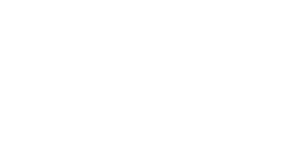

In [71]:
ax = sns.displot(prop_tax_rev_per_capita_change, x="percent_change_from78to79")
ax.axes[0,0].set_xlabel("property tax revenue per capita % change from 1978 to 1979")
plt.gcf().set_size_inches(12, 8) # work for Facetgrid obj
plt.show()

In [72]:
city_non_decrease = prop_tax_rev_per_capita_change[prop_tax_rev_per_capita_change["percent_change_from78to79"] >= 0].copy()
print("cities with property tax rev per capita increased or not changed:")
city_non_decrease

cities with property tax rev per capita increased or not changed:


,ID,1978,1979,percent_change_from78to79,County,Name
33,052015701,5.252183,14.621087,1.783811,015,ridgecrest city
92,052027003,65.900088,97.523810,0.479874,027,gonzales city
201,052056702,7.934351,11.365975,0.432502,056,thousand oaks city


In [73]:
TOP_N = 15
top_15 = prop_tax_rev_per_capita_change.sort_values("percent_change_from78to79").head(TOP_N)
top_15

,ID,1978,1979,percent_change_from78to79,County,Name
74,052019506,22.272347,0.000000,-1.000000,019,norwalk city
56,052019024,17.689734,0.065514,-0.996297,019,la puente city
76,052019508,33.929715,2.367331,-0.930228,019,pico rivera city
55,052019023,52.154484,5.954475,-0.885830,019,lakewood city
165,052041801,362.944650,54.137203,-0.850839,041,foster city
79,052019520,55.670363,9.267166,-0.833535,019,la mirada city
82,052019801,143.561959,28.267716,-0.803097,019,carson city
46,052019013,211.371713,42.035842,-0.801128,019,cerritos city
73,052019050,42.380172,9.307792,-0.780374,019,downey city
138,052036701,24.416534,5.366585,-0.780207,036,victorville city


## 1980 racial composition 

In [74]:
RACE_CONTEXT_COLS = ["GISJOIN","YEAR","REGIONA","DIVISIONA","STATE","STATEA","SMSAA","COUNTYA",
                "CTY_SUBA","PLACE","PLACEA","TRACTA", "SCSAA","URB_AREAA","CDA","AIANHHA","ZIPA","AREANAME"]
RACE_VAL_COlS = {
    "C9L001":      "Spanish_White",
    "C9L002":      "Spanish_Black",
    "C9L003":      "Spanish_AIAN",
    "C9L004":      "Spanish_AAPI",
    "C9L005":      "Spanish_other",
    "C9L006":      "non-Hispanic_White",
    "C9L007":      "non-Hispanic_Black",
    "C9L008":      "non-Hispanic_AIAN",
    "C9L009":      "non-Hispanic_AAPI",
    "C9L010":      "non-Hispanic_other",
}


race = pd.read_csv(f"{RAW_DATA_DIR}/supplemental_data/nhgis0010_csv_1980_race_place/nhgis0010_ds105_1980_place.csv",
                    usecols=RACE_CONTEXT_COLS + list(RACE_VAL_COlS.keys()), 
                    dtype={col: str for col in RACE_CONTEXT_COLS})

race = race.rename(RACE_VAL_COlS, axis=1)


In [75]:
race = race.loc[race["STATEA"] == "06"].copy()
race["STATE"].unique()

array(['California'], dtype=object)

In [76]:
normalize_str_cols(race, RACE_CONTEXT_COLS)

In [77]:
race["total_pop"] = race[list(RACE_VAL_COlS.values())].sum(axis=1)

In [78]:
# race[list(RACE_VAL_COlS.values()) + ["total_pop"]].describe()
# no NA

In [79]:
latino_cols = ["Spanish_" + r for r in ["White", "Black", "AIAN", "AAPI", "other"]]
race["Latino"] = race[latino_cols].sum(axis=1)
race.drop(columns=latino_cols, inplace=True)

In [80]:
race.to_csv(f"{INTERIM_DATA_DIR}/CA_race_by_Hispanish_place_1980.csv", index=False)

In [81]:
RACE_CATES = ['non-Hispanic_White', 'non-Hispanic_Black', 'non-Hispanic_AIAN', 'non-Hispanic_AAPI', 'non-Hispanic_other', 'Latino']
for col in RACE_CATES:
    race[col] = race[col]/race["total_pop"]

In [82]:
def get_race_by_merge(prop_tax_rev_per_capita_change, race_df):
    _df = prop_tax_rev_per_capita_change.copy()
    
    merge_1 = _df.merge(race_df, how="left", left_on="Name", right_on="AREANAME")

    non_match_1 = _df[merge_1["non-Hispanic_White"].isna()].copy().reset_index(drop=True)
    non_match_1["Name"] = np.where(
        non_match_1["Name"].str.endswith("city"), non_match_1["Name"] + " city", non_match_1["Name"]
    )
    merge_2 = non_match_1.merge(race_df, how="left", left_on="Name", right_on="AREANAME")
    
    non_match_2 = non_match_1[merge_2["non-Hispanic_White"].isna()].copy().reset_index(drop=True)
    non_match_2.loc[non_match_2["ID"] == "052038001", "Name"] = "san francisco city"
    non_match_2.loc[non_match_2["ID"] == "052056005", "Name"] = "san buenaventura (ventura) city"
    merge_3 = non_match_2.merge(race_df, how="left", left_on="Name", right_on="AREANAME")
    
    assert merge_3["non-Hispanic_White"].isna().sum() == 0
    res = pd.concat([merge_1[~merge_1["non-Hispanic_White"].isna()],
                     merge_2[~merge_2["non-Hispanic_White"].isna()], 
                     merge_3], ignore_index=True)
    assert res.shape[0] == _df.shape[0]
    
    return res
    

In [83]:
racial_comp = race[["AREANAME"] + RACE_CATES + ["total_pop"]].copy()
pct_chg_with_race = get_race_by_merge(prop_tax_rev_per_capita_change, racial_comp)

In [84]:
for r in RACE_CATES:
    pct_chg_with_race[r + "_percentile_rank"] = pct_chg_with_race[r].rank(pct=True)
pct_chg_with_race["prop_tax_rev_pct_chg_percentile_rank"] = pct_chg_with_race["percent_change_from78to79"].rank(pct=True)
topn_with_race = pct_chg_with_race.sort_values("percent_change_from78to79").head(TOP_N)

pearson corr


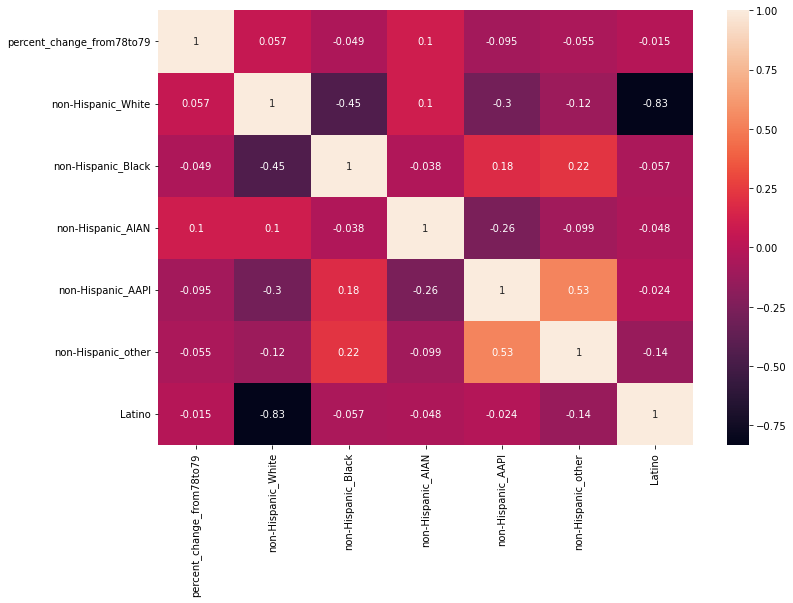

In [85]:
%matplotlib inline
print("pearson corr")
corr_matrix = pct_chg_with_race[["percent_change_from78to79"]+RACE_CATES].corr("pearson")
sns.heatmap(corr_matrix, annot=True)
plt.gcf().set_size_inches(12, 8)


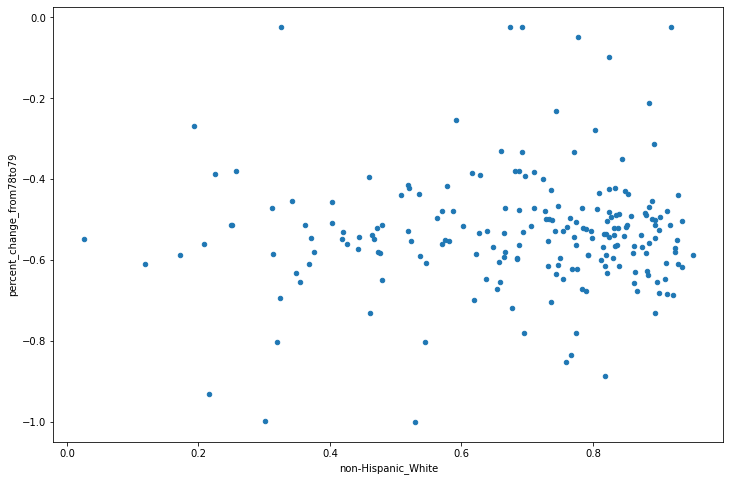

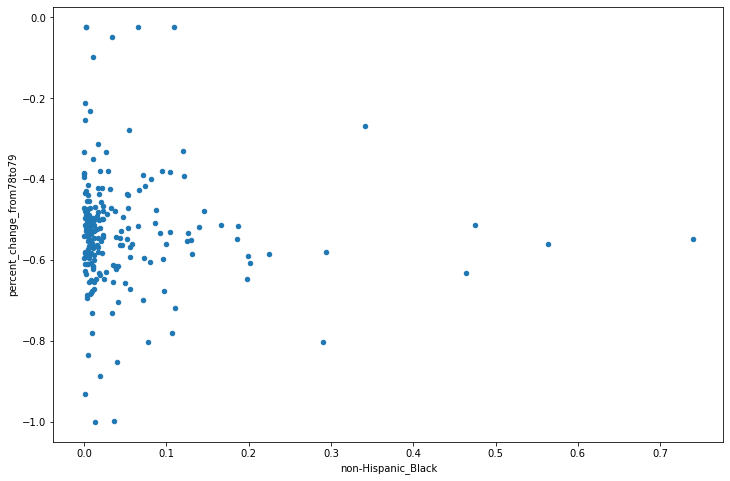

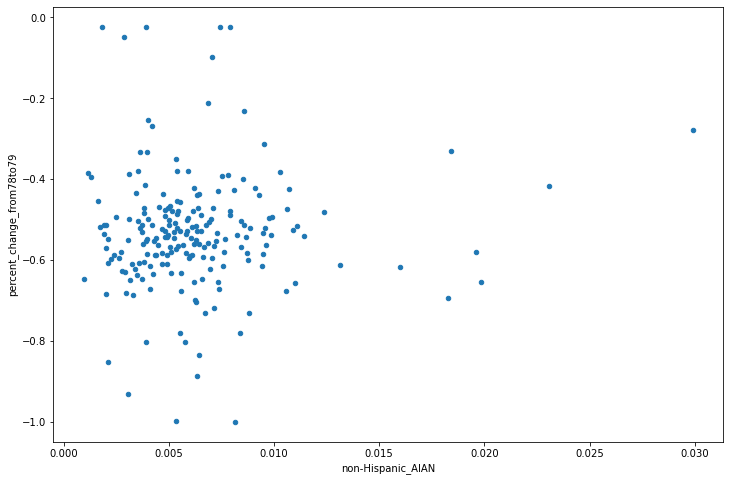

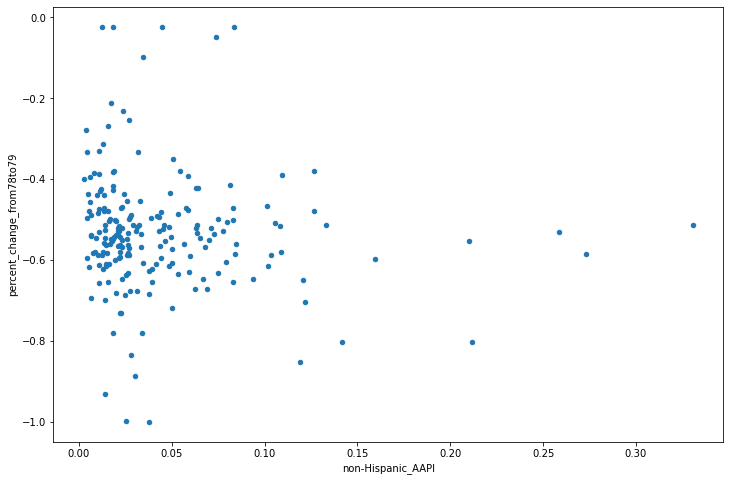

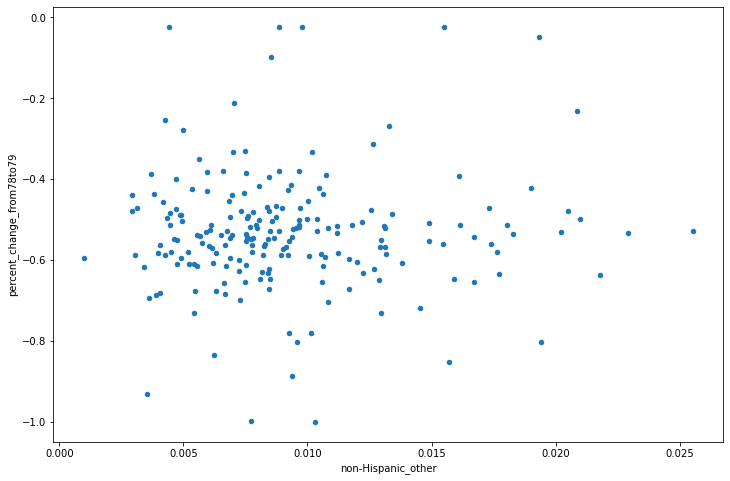

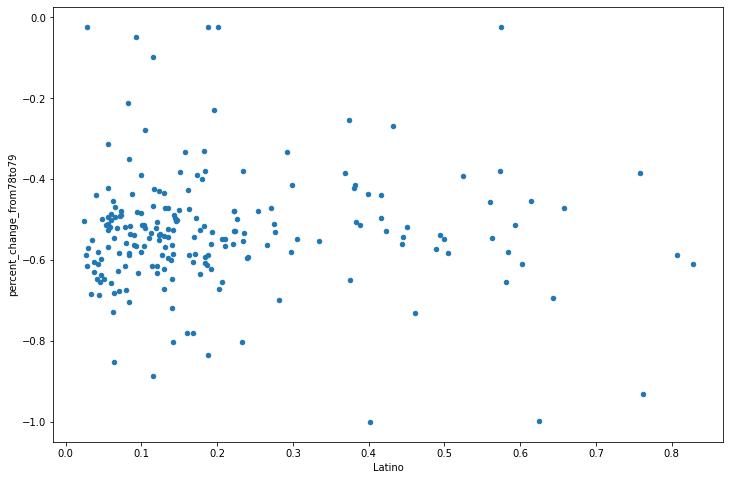

In [86]:
%matplotlib inline

for r in RACE_CATES:
    ax=pct_chg_with_race[pct_chg_with_race["percent_change_from78to79"]<0].plot.scatter(x=r, y="percent_change_from78to79")
    plt.gcf().set_size_inches(12, 8)
    plt.savefig(f'{r}.png')

spearman corr


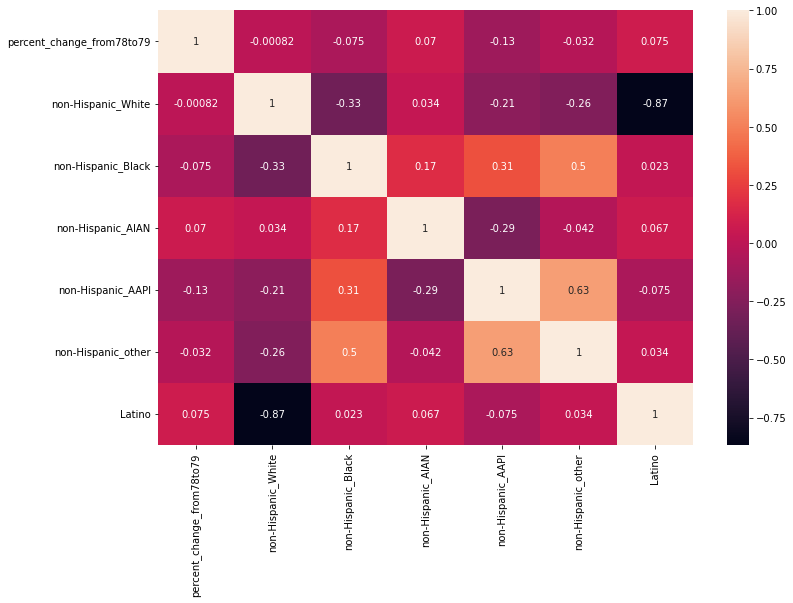

In [87]:
%matplotlib inline
print("spearman corr")
corr_matrix = pct_chg_with_race[["percent_change_from78to79"]+RACE_CATES].corr("spearman")
sns.heatmap(corr_matrix, annot=True)
plt.gcf().set_size_inches(12, 8)

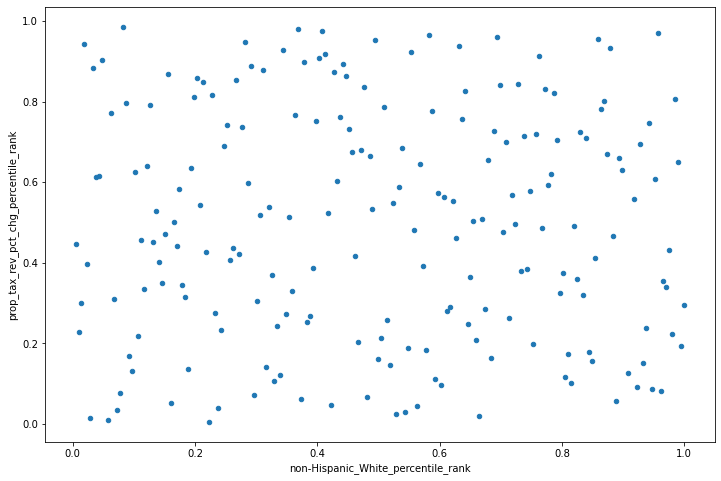

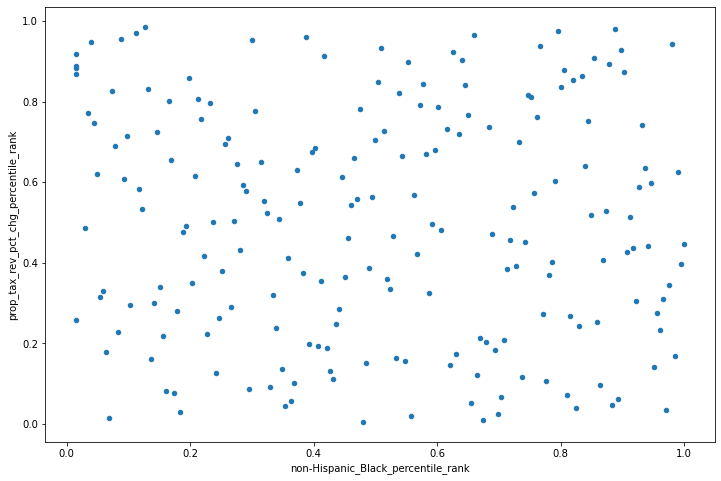

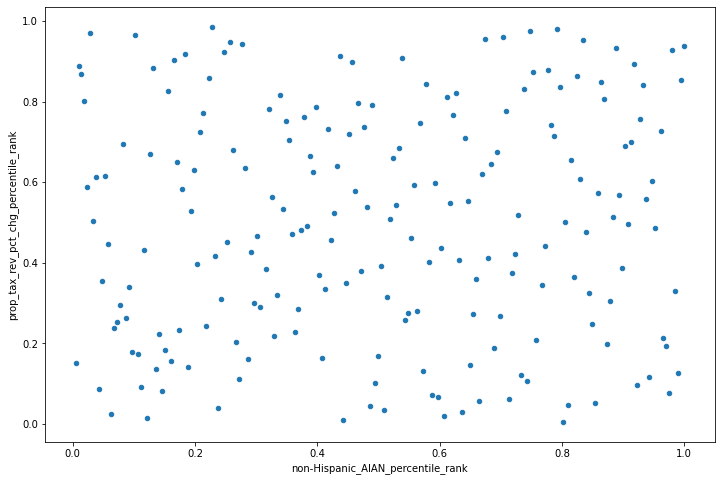

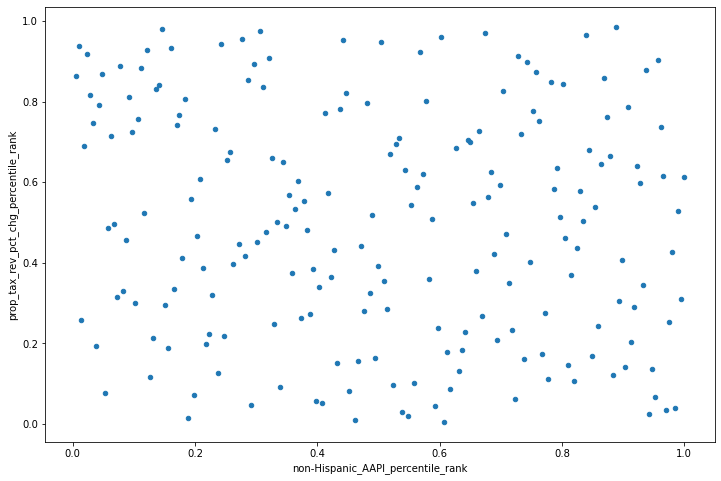

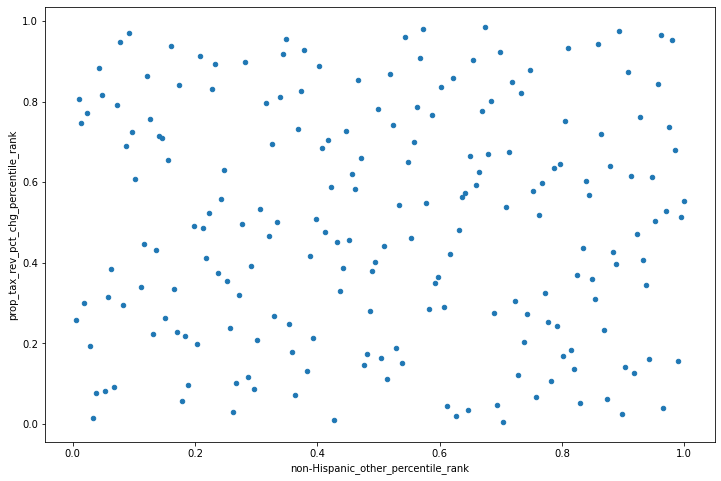

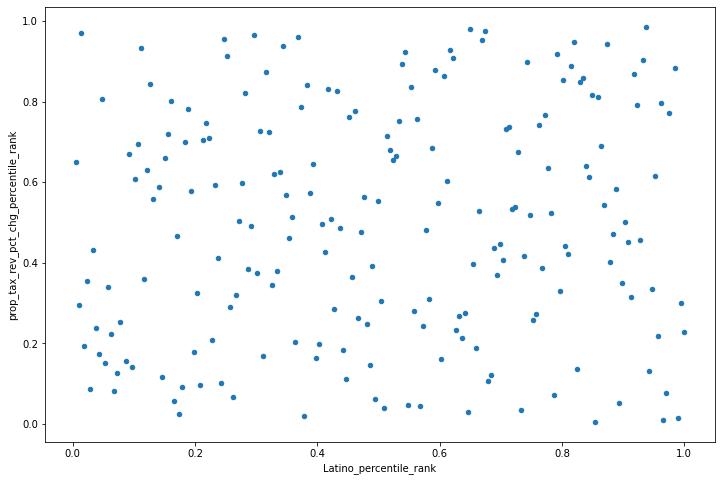

In [88]:
%matplotlib inline

for r in RACE_CATES:
    r = r + "_percentile_rank"
    ax=pct_chg_with_race[pct_chg_with_race["percent_change_from78to79"]<0].plot.scatter(x=r, y="prop_tax_rev_pct_chg_percentile_rank")
    plt.gcf().set_size_inches(12, 8)
    plt.savefig(f'{r}.png')

## Median Household Income in 1979 ( only sample-based data available in Census 1980)

In [89]:
INCOME_CONTEXT_COLS = ["GISJOIN","YEAR","REGIONA","DIVISIONA","STATE","STATEA","SMSAA","COUNTYA",
                       "CTY_SUBA","PLACE","PLACEA","TRACTA", "BLCK_GRPA", "ENUMDISTA",
                       "SCSAA","URB_AREAA","CDA","AIANHHA", "MCDSEQNOA", "ZIPA","AREANAME"]
INCOME_VAL_COL_MAP = {"DIE001": "median_household_income"}

income = pd.read_csv(
    f"{RAW_DATA_DIR}/supplemental_data/nhgis0013_1979_median_household_income/nhgis0013_ds107_1980_place.csv",
    usecols=INCOME_CONTEXT_COLS + list(INCOME_VAL_COL_MAP.keys()), 
    dtype={col: str for col in INCOME_CONTEXT_COLS}
)

income = income.rename(INCOME_VAL_COL_MAP, axis=1)

In [90]:
income = income.loc[income["STATEA"] == "06"].copy()
print(income["STATE"].unique())

['California']


In [91]:
normalize_str_cols(income, INCOME_CONTEXT_COLS)

# 'san buenaventura %ventura<'
income.loc[income["GISJOIN"]=="g0602460", "AREANAME"] = "san buenaventura (ventura)"

In [92]:
# CA 
income.shape

(781, 22)

In [93]:
# no NA
income.describe()

,SMSAA,COUNTYA,CTY_SUBA,TRACTA,BLCK_GRPA,ENUMDISTA,SCSAA,URB_AREAA,CDA,AIANHHA,MCDSEQNOA,ZIPA,median_household_income
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,781.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18441.687580
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7560.840702
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6328.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13635.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16590.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21165.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75001.000000


In [94]:
income.to_csv(f"{INTERIM_DATA_DIR}/income_CA_place_1979.csv", index=False)

In [95]:
def get_income_by_merge(prop_tax_rev_per_capita_change, income_df):
    income_df = income_df[["AREANAME", "median_household_income"]].copy()
    df = prop_tax_rev_per_capita_change.copy()
    
    merge_1 = df.merge(income_df, how="left", left_on="Name", right_on="AREANAME")
    non_match_1 = df[merge_1["median_household_income"].isna()].reset_index(drop=True)
    
    non_match_1["Name"] = non_match_1["Name"].str.replace(r" city$", "", regex=True)
    merge_2 = non_match_1.merge(income_df, how="left", left_on="Name", right_on="AREANAME")
    non_match_2 = non_match_1[merge_2["median_household_income"].isna()].reset_index(drop=True)
    
    non_match_2["Name"] = non_match_2["Name"].str.replace(r" town$", "", regex=True)
    merge_3 = non_match_2.merge(income_df, how="left", left_on="Name", right_on="AREANAME")
    non_match_3 = non_match_2[merge_3["median_household_income"].isna()].reset_index(drop=True)
    
    non_match_3.loc[non_match_3["ID"] == "052038001", "Name"] = "san francisco"
    non_match_3.loc[non_match_3["ID"] == "052056005", "Name"] = "san buenaventura (ventura)"
    merge_4 = non_match_3.merge(income_df, how="left", left_on="Name", right_on="AREANAME")
    
    assert merge_4["median_household_income"].isna().sum() == 0
    res = pd.concat([merge_1[~merge_1["median_household_income"].isna()],
                     merge_2[~merge_2["median_household_income"].isna()], 
                     merge_3[~merge_3["median_household_income"].isna()],
                     merge_4], ignore_index=True)
    assert res.shape[0] == df.shape[0]
    
    return res.drop(columns="AREANAME")
    
pct_chg_with_income = get_income_by_merge(prop_tax_rev_per_capita_change, income)

In [96]:
pct_chg_with_income["prop_tax_rev_pct_chg_percentile_rank"] = pct_chg_with_income["percent_change_from78to79"].rank(pct=True)
pct_chg_with_income["median_household_income_percentile_rank"] = pct_chg_with_income["median_household_income"].rank(pct=True)
topn_with_income = pct_chg_with_income.sort_values("percent_change_from78to79").head(TOP_N)

In [97]:
all_cities = pct_chg_with_race[[
    'ID', 'County', 'Name', 'total_pop', 'percent_change_from78to79', 
    'non-Hispanic_White', 'non-Hispanic_Black',
    'non-Hispanic_AIAN', 'non-Hispanic_AAPI', 'non-Hispanic_other',
    'Latino',  'non-Hispanic_White_percentile_rank',
    'non-Hispanic_Black_percentile_rank',
    'non-Hispanic_AIAN_percentile_rank',
    'non-Hispanic_AAPI_percentile_rank',
    'non-Hispanic_other_percentile_rank', 'Latino_percentile_rank',
    'prop_tax_rev_pct_chg_percentile_rank'
]].merge(pct_chg_with_income[["ID", "median_household_income", "median_household_income_percentile_rank"]],
         how="inner", on="ID")
all_cities.sort_values("percent_change_from78to79", inplace=True)
assert all_cities.shape[0] == pct_chg_with_race.shape[0]

### output

In [98]:
all_cities.to_csv(f"{INTERIM_DATA_DIR}/cities_pct_chg_prop_tax_rev_per_capita_from78to79.csv", index=False)

In [99]:
print("pearson corr")
corr_matrix = pct_chg_with_income[["percent_change_from78to79", "median_household_income"]].corr("pearson")
corr_matrix

pearson corr


,percent_change_from78to79,median_household_income
percent_change_from78to79,1.00000,-0.01768
median_household_income,-0.01768,1.00000


In [100]:
print("spearman corr")
corr_matrix = pct_chg_with_income[["percent_change_from78to79", "median_household_income"]].corr("spearman")
corr_matrix

spearman corr


,percent_change_from78to79,median_household_income
percent_change_from78to79,1.000000,-0.202477
median_household_income,-0.202477,1.000000


In [103]:
import statsmodels.api as sm
import matplotlib.lines as mlines
import scipy

# bootstrap
def smooth(x, y, xgrid):
    samples = np.random.choice(len(x), 50, replace=True) # take 50 samples to interpolate lowess line
    y_s = y[samples]
    x_s = x[samples]
    y_sm = sm.nonparametric.lowess(y_s, x_s, return_sorted = False)
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid

def lowess_with_confidence_interval(x, y):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(x, y, c='black')
    smoothing_line = sm.nonparametric.lowess(y, x)
    plt.plot(smoothing_line[:,0], smoothing_line[:,1], '-', color = 'r')

    # CI
    xgrid = np.linspace(x.min(),x.max())
    K = 200 # number of bootstrap samples
    bootstrap_samples = np.stack([smooth(x, y, xgrid) for k in range(K)]).T
    c25 = np.nanpercentile(bootstrap_samples, 2.5, axis=1) #2.5 percent
    c975 = np.nanpercentile(bootstrap_samples, 97.5, axis=1) # 97.5 percent
    plt.fill_between(xgrid, c25, c975, alpha=0.25)
    
    return ax


<IPython.core.display.Javascript object>


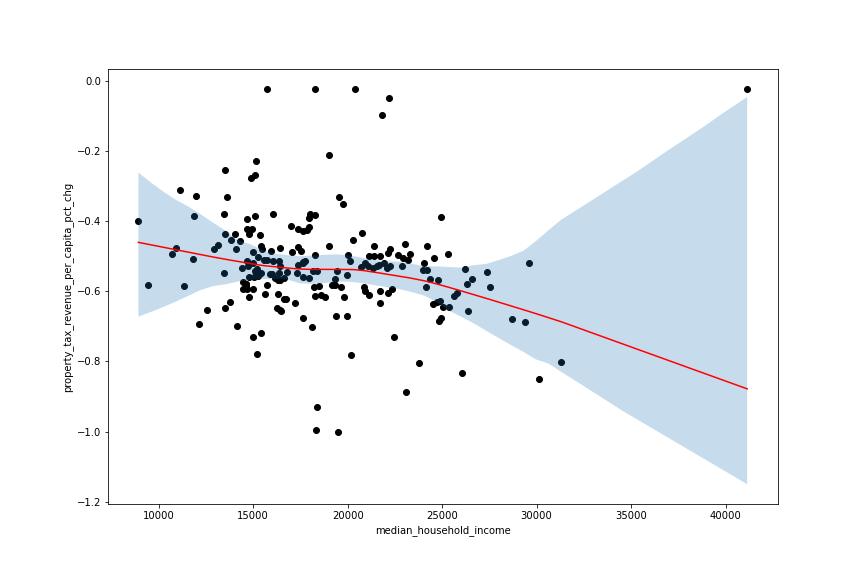

/usr/local/opt/anaconda3/envs/prop13_analysis/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [105]:
%matplotlib notebook
decreased_pct_chg_with_income = pct_chg_with_income[pct_chg_with_income["percent_change_from78to79"]<0]
ax = lowess_with_confidence_interval(
    decreased_pct_chg_with_income["median_household_income"].values, 
    decreased_pct_chg_with_income["percent_change_from78to79"].values
)
ax.set_xlabel("median_household_income")
ax.set_ylabel("property_tax_revenue_per_capita_pct_chg")
plt.show()

In [114]:
decreased_pct_chg_with_income["median_household_income_grp"] = np.where(
    decreased_pct_chg_with_income["median_household_income"] < 17430, "<17430", "17430 to 20400"
)
decreased_pct_chg_with_income["median_household_income_grp"] = np.where(
    decreased_pct_chg_with_income["median_household_income"] > 20400, ">20400", 
    decreased_pct_chg_with_income["median_household_income_grp"]
)
stat_for_median_household_income_grp = decreased_pct_chg_with_income.groupby("median_household_income_grp")["percent_change_from78to79"].agg(
    ["mean", "median"]
).reset_index()
stat_for_median_household_income_grp["order"] = stat_for_median_household_income_grp["median_household_income_grp"].replace(
{"<17430" : 0, "17430 to 20400": 1, ">20400": 2}
)
stat_for_median_household_income_grp = stat_for_median_household_income_grp.sort_values("order").drop(columns="order")
print(stat_for_median_household_income_grp)
stat_for_median_household_income_grp.to_csv(f"{INTERIM_DATA_DIR}/pct_chg_prop_tax_per_capita_from78to79_stat_by_median_household_income_grp.csv", index=False)

  median_household_income_grp      mean    median
1                      <17430 -0.512654 -0.527009
0              17430 to 20400 -0.534237 -0.543054
2                      >20400 -0.556357 -0.538153


/var/folders/zb/d8phfv110gv94fcv_k4dlnfw0000gn/T/ipykernel_4386/62775198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decreased_pct_chg_with_income["median_household_income_grp"] = np.where(
/var/folders/zb/d8phfv110gv94fcv_k4dlnfw0000gn/T/ipykernel_4386/62775198.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decreased_pct_chg_with_income["median_household_income_grp"] = np.where(


<IPython.core.display.Javascript object>


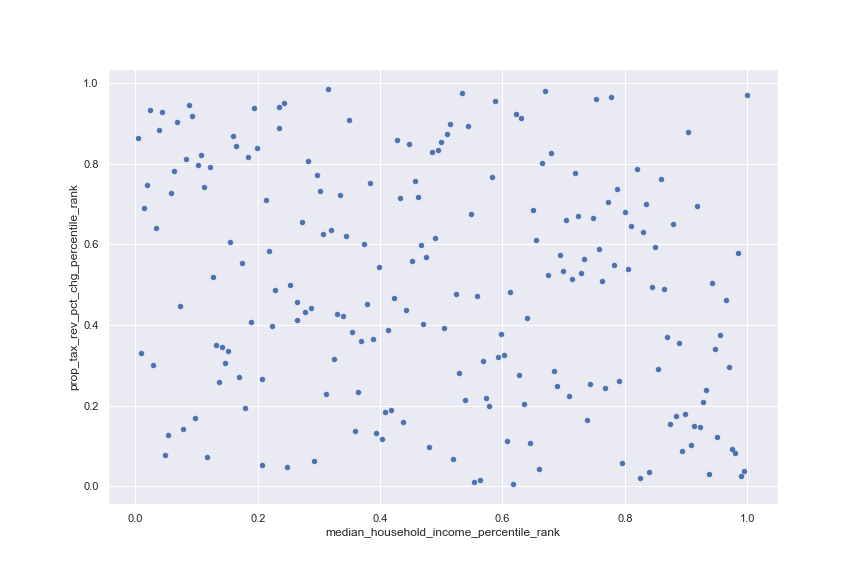

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [335]:
%matplotlib notebook

ax=decreased_pct_chg_with_income.plot.scatter(x="median_household_income_percentile_rank", y="prop_tax_rev_pct_chg_percentile_rank")
plt.gcf().set_size_inches(12, 8)

# output: get property tax revenue in 1977 and 1972

In [21]:
prop_tax_1972 = full_data.loc[full_data["Year4"] == "1972", :].copy()
prop_tax_1972.to_csv("../../../data/interim/prop_tax_rev_city_1972.csv", index=False)

In [22]:
prop_tax_1977 = full_data.loc[full_data["Year4"] == "1977", :].copy()
prop_tax_1977.to_csv("../../../data/interim/prop_tax_rev_city_1977.csv", index=False)


# get property tax revenue in 1977 and 1982

In [23]:
"10,000,000 $ in 1977 to 1982"
CPI = 1.598023064
data_77_82 = full_data.loc[(full_data["Year4"] == "1977") | (full_data["Year4"] == "1982")]
print(data_77_82.describe())
data_77_82.loc[:, "Total_Revenue_adj"] = data_77_82["Total_Revenue"]
data_77_82.loc[full_data["Year4"] == "1977", "Total_Revenue_adj"] = data_77_82["Total_Revenue_adj"] * CPI
data_77_82.loc[:, "Property_Tax_adj"] = data_77_82["Property_Tax"]
data_77_82.loc[full_data["Year4"] == "1977", "Property_Tax_adj"] = data_77_82["Property_Tax_adj"] * CPI
data_77_82

         Population  Total_Revenue   Property_Tax
count  8.410000e+02   8.410000e+02     841.000000
mean   4.042157e+04   2.381634e+04    3315.774078
std    1.540869e+05   1.526370e+05   18544.051743
min    0.000000e+00   0.000000e+00       0.000000
25%    4.773000e+03   1.553000e+03     191.000000
50%    1.539900e+04   4.831000e+03     701.000000
75%    3.686600e+04   1.310600e+04    2110.000000
max    2.968579e+06   3.346262e+06  299289.000000


/usr/local/opt/anaconda3/envs/ds/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/opt/anaconda3/envs/ds/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,ID,Year4,State_Code,Type_Code,County,Name,FYEndDate,YearPop,Population,Total_Revenue,Property_Tax,Total_Revenue_adj,Property_Tax_adj
8,052001001,1977,05,2,001,alameda city,630,None,72017,25671,4819,41022.850076,7700.873145
13,052001001,1982,05,2,001,alameda city,630,None,63852,41632,4327,41632.000000,4327.000000
43,052001002,1977,05,2,001,albany city,630,None,14203,3578,1000,5717.726523,1598.023064
46,052001002,1982,05,2,001,albany city,630,None,15130,3813,799,3813.000000,799.000000
74,052001003,1977,05,2,001,berkeley city,1231,None,110465,44616,13575,71297.397023,21693.163094
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13032,052057003,1982,05,2,057,woodland city,630,None,30235,16583,2169,16583.000000,2169.000000
13075,052058001,1977,05,2,058,marysville city,630,None,9253,3303,546,5278.270180,872.520593
13078,052058001,1982,05,2,058,marysville city,630,None,9898,4252,774,4252.000000,774.000000
13091,052058002,1977,05,2,058,wheatland city,630,None,1366,265,29,423.476112,46.342669


In [25]:
change_77_82 = data_77_82[["ID", "Year4", "Total_Revenue_adj", "Property_Tax_adj"]].copy()
change_77_82["prop_tax_ratio"] = change_77_82["Property_Tax_adj"] / change_77_82["Total_Revenue_adj"]
change_77_82 = change_77_82.pivot(index=["ID"], columns="Year4")

In [26]:
change_77_82["total_rev_change_in_percentage"] = change_77_82[("Total_Revenue_adj", "1982")] / change_77_82[("Total_Revenue_adj", "1977")] - 1
change_77_82["prop_tax_change_in_percentage"] = change_77_82[("Property_Tax_adj", "1982")] / change_77_82[("Property_Tax_adj", "1977")] - 1
change_77_82["prop_tax_ratio_change"] = change_77_82[("prop_tax_ratio", "1982")] - change_77_82[("prop_tax_ratio", "1977")]

In [26]:
change_77_82 = change_77_82.loc[(~change_77_82["total_rev_change_in_percentage"].isna()) &
                                (~change_77_82["prop_tax_change_in_percentage"].isna()) &
                                (~change_77_82["prop_tax_ratio_change"].isna())]
change_77_82 = change_77_82.merge(ID2city_name, how="left", left_index=True, right_index=True)

/usr/local/opt/anaconda3/envs/ds/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [27]:
change_77_82.shape[0]

412

In [28]:
change_77_82[change_77_82[('prop_tax_ratio_change', '')] < 0].shape

(352, 11)

In [29]:
change_77_82.sort_values(by=('prop_tax_ratio_change', ""))

,"(Total_Revenue_adj, 1977)","(Total_Revenue_adj, 1982)","(Property_Tax_adj, 1977)","(Property_Tax_adj, 1982)","(prop_tax_ratio, 1977)","(prop_tax_ratio, 1982)","(total_rev_change_in_percentage, )","(prop_tax_change_in_percentage, )","(prop_tax_ratio_change, )",County,Name
ID,,,,,,,,,,,
052027003,4901.136737,1286.0,3005.881383,182.0,0.613303,0.141524,-0.737612,-0.939452,-0.471779,027,gonzales city
052019901,7640.148269,4726.0,3371.828665,241.0,0.441330,0.050994,-0.381426,-0.928525,-0.390336,019,rancho palos verdes city
052021006,984.382207,935.0,669.571664,311.0,0.680195,0.332620,-0.050166,-0.535524,-0.347574,021,ross town
052019702,468.220758,309.0,268.467875,70.0,0.573379,0.226537,-0.340055,-0.739261,-0.346842,019,hidden hills city
052019517,1097.841845,540.0,592.866557,146.0,0.540029,0.270370,-0.508126,-0.753739,-0.269659,019,rolling hills city
...,...,...,...,...,...,...,...,...,...,...,...
052030008,45666.705100,48232.0,10484.629323,17081.0,0.229590,0.354142,0.056174,0.629147,0.124552,030,garden grove city
052007008,16023.377263,13885.0,2353.887973,3929.0,0.146903,0.282967,-0.133454,0.669153,0.136064,007,pittsburg city
052033901,2841.285008,5855.0,0.000000,1372.0,0.000000,0.234330,1.060687,inf,0.234330,033,rancho mirage city


In [30]:
change_77_82.columns

Index([         ('Total_Revenue_adj', '1977'),
                ('Total_Revenue_adj', '1982'),
                 ('Property_Tax_adj', '1977'),
                 ('Property_Tax_adj', '1982'),
                   ('prop_tax_ratio', '1977'),
                   ('prop_tax_ratio', '1982'),
       ('total_rev_change_in_percentage', ''),
        ('prop_tax_change_in_percentage', ''),
                ('prop_tax_ratio_change', ''),
                                     'County',
                                       'Name'],
      dtype='object')

In [31]:
change_77_82.columns = ['Total_Revenue_adj_1977', 'Total_Revenue_adj_1982',
                        'Property_Tax_adj_1977',  'Property_Tax_adj_1982',
                        'prop_tax_ratio_1977',     'prop_tax_ratio_1982',
                        'total_rev_change_in_percentage',  'prop_tax_change_in_percentage',
                        'prop_tax_ratio_change',    'County', 'Name']

In [32]:
change_77_82.describe()

,Total_Revenue_adj_1977,Total_Revenue_adj_1982,Property_Tax_adj_1977,Property_Tax_adj_1982,prop_tax_ratio_1977,prop_tax_ratio_1982,total_rev_change_in_percentage,prop_tax_change_in_percentage,prop_tax_ratio_change
count,4.120000e+02,4.120000e+02,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,2.827672e+04,3.074050e+04,5236.721581,3471.669903,0.190670,0.137826,0.104994,inf,-0.052845
std,1.744162e+05,1.886849e+05,30847.203247,18161.308821,0.109197,0.081602,0.516946,NaN,0.073729
min,7.191104e+01,5.200000e+01,0.000000,0.000000,0.000000,0.000000,-0.823151,-1.000000,-0.471779
25%,2.062648e+03,1.969250e+03,301.227348,200.250000,0.118659,0.084452,-0.126217,-0.388144,-0.084158
50%,5.951038e+03,6.224500e+03,1049.102142,795.000000,0.166185,0.121814,0.017384,-0.268077,-0.047539
75%,1.603456e+04,1.821975e+04,3231.602141,2305.750000,0.237702,0.169215,0.191772,-0.120654,-0.016927
max,3.117455e+06,3.346262e+06,478270.724801,295354.000000,0.680195,0.585336,5.297686,inf,0.331749


In [33]:
# 1977 prop tax = 0(thousands), so prop_tax_change_in_percentage == inf
change_77_82[change_77_82['prop_tax_change_in_percentage'] == float("inf")].merge(
    data_77_82.loc[data_77_82["Year4"] == "1977", ["ID", "Year4", "Population","Property_Tax"]],
    how="left", left_index=True, right_on="ID")

,Total_Revenue_adj_1977,Total_Revenue_adj_1982,Property_Tax_adj_1977,Property_Tax_adj_1982,prop_tax_ratio_1977,prop_tax_ratio_1982,total_rev_change_in_percentage,prop_tax_change_in_percentage,prop_tax_ratio_change,County,Name,ID,Year4,Population,Property_Tax
4363,9001.663920,9019.0,0.0,3.0,0.0,0.000333,0.001926,inf,0.000333,019,bellflower city,052019501,1977,51145,0
8065,2841.285008,5855.0,0.0,1372.0,0.0,0.234330,1.060687,inf,0.234330,033,rancho mirage city,052033901,1977,4342,0
8948,4335.436573,6968.0,0.0,575.0,0.0,0.082520,0.607220,inf,0.082520,036,victorville city,052036701,1977,12377,0


rancho mirage city, Riverside County 1973 incorporate
The City did not have a separate property tax rate prior to the voter enactment of Proposition 13 in 1978
https://ranchomirageca.gov/residents/

NO-PROPERTY-TAX CITIES in "No-Property-Tax Cities After Proposition 13.pdf" page 4
victorville city, San Bernardino County
bellflower city, Los Angeles County

In [34]:
change_77_82 = change_77_82[change_77_82['prop_tax_change_in_percentage'] != float("inf")].copy()
change_77_82.describe()

,Total_Revenue_adj_1977,Total_Revenue_adj_1982,Property_Tax_adj_1977,Property_Tax_adj_1982,prop_tax_ratio_1977,prop_tax_ratio_1982,total_rev_change_in_percentage,prop_tax_change_in_percentage,prop_tax_ratio_change
count,4.090000e+02,4.090000e+02,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,2.844458e+04,3.091257e+04,5275.132741,3492.366748,0.192069,0.138061,0.101681,-0.201679,-0.054008
std,1.750450e+05,1.893665e+05,30957.123871,18226.274773,0.108363,0.081432,0.516046,0.548408,0.072254
min,7.191104e+01,5.200000e+01,3.196046,0.000000,0.010870,0.000000,-0.823151,-1.000000,-0.471779
25%,2.061450e+03,1.949000e+03,305.222405,201.000000,0.119473,0.084614,-0.127124,-0.389523,-0.084395
50%,5.963822e+03,6.113000e+03,1077.067545,799.000000,0.166922,0.121849,0.017226,-0.269931,-0.048376
75%,1.606812e+04,1.830000e+04,3232.800658,2308.000000,0.238452,0.169050,0.190510,-0.123918,-0.017399
max,3.117455e+06,3.346262e+06,478270.724801,295354.000000,0.680195,0.585336,5.297686,8.773767,0.331749


In [35]:
change_77_82.head()

,Total_Revenue_adj_1977,Total_Revenue_adj_1982,Property_Tax_adj_1977,Property_Tax_adj_1982,prop_tax_ratio_1977,prop_tax_ratio_1982,total_rev_change_in_percentage,prop_tax_change_in_percentage,prop_tax_ratio_change,County,Name
ID,,,,,,,,,,,
052001001,41022.850076,41632.0,7700.873145,4327.0,0.187722,0.103934,0.014849,-0.438116,-0.083787,001,alameda city
052001002,5717.726523,3813.0,1598.023064,799.0,0.279486,0.209546,-0.333127,-0.500007,-0.069939,001,albany city
052001003,71297.397023,61645.0,21693.163094,11119.0,0.304263,0.180371,-0.135382,-0.487442,-0.123892,001,berkeley city
052001004,5156.820428,9493.0,1506.935749,1654.0,0.292222,0.174234,0.840863,0.097592,-0.117988,001,emeryville city
052001005,35958.714986,36435.0,9249.357494,6399.0,0.257222,0.175628,0.013245,-0.308168,-0.081594,001,fremont city


# output: 18 cities with tax rates, property tax revenue, and total revenue

In [36]:
def normalize_str_cols(df, str_columns):
    for col in str_columns:
        df[col] = df[col].str.strip()
        df[col] = df[col].str.lower()
        df[col] = df[col].map(lambda x: None if x == "" else x)

In [37]:
city_18_str_cols = ['County', 'Area', 'ID']
city_18 = pd.read_csv("../../../data/interim/city_with_tax_rate_in_1977_and_1982.csv", dtype={c: str for c in city_18_str_cols})
city_18.drop("State", axis=1, inplace=True)

normalize_str_cols(city_18, ['County', 'Area', 'ID'])
# normalize gov codes
city_18['ID'] = city_18['ID'].str.zfill(9)

city_18.head()

,ID,County,Area,Nom_Tax_Rate_All_Res_Med_1977,Nom_Tax_Rate_All_Res_Med_1982,Nom_Tax_Rate_Res_All_SFH_Med_1977,Nom_Tax_Rate_Res_All_SFH_Med_1982,Eff_Tax_Rate_All_Res_Med_1977,Eff_Tax_Rate_All_Res_Med_1982,Eff_Tax_Rate_Res_All_SFH_Med_1977,Eff_Tax_Rate_Res_All_SFH_Med_1982,AV_Ratio_All_Res_Med_1977,AV_Ratio_All_Res_Med_1982
0,052001001,"alameda county, ca",alameda city,13.52,1.19,13.52,1.19,2.31,0.75,2.41,0.75,19.0,62.87
1,052001003,"alameda county, ca",berkeley city,15.78,1.18,15.78,1.18,2.53,0.61,2.45,0.52,18.7,51.83
2,052001005,"alameda county, ca",fremont city,12.51,1.35,12.51,1.35,1.93,0.74,1.93,0.74,19.1,62.15
3,052001006,"alameda county, ca",hayward city,12.85,1.31,12.85,1.31,1.99,0.71,1.98,0.71,19.1,71.07
4,052001009,"alameda county, ca",oakland city,14.45,1.31,14.45,1.31,2.42,0.60,2.38,0.60,19.2,50.60


In [38]:
city18_with_rev = city_18.merge(change_77_82.drop("County", axis=1), how="left", on="ID")
city18_with_rev.rename(columns = {"Area": "name_in_taxrate", "Name": "name_in_rev"}, inplace=True)
_order_cols = city18_with_rev.columns
city18_with_rev = city18_with_rev[_order_cols[:3].tolist() + [_order_cols[-1]]  + _order_cols[3:-1].tolist()].copy()

In [39]:
city18_with_rev

,ID,County,name_in_taxrate,name_in_rev,Nom_Tax_Rate_All_Res_Med_1977,Nom_Tax_Rate_All_Res_Med_1982,Nom_Tax_Rate_Res_All_SFH_Med_1977,Nom_Tax_Rate_Res_All_SFH_Med_1982,Eff_Tax_Rate_All_Res_Med_1977,Eff_Tax_Rate_All_Res_Med_1982,...,AV_Ratio_All_Res_Med_1982,Total_Revenue_adj_1977,Total_Revenue_adj_1982,Property_Tax_adj_1977,Property_Tax_adj_1982,prop_tax_ratio_1977,prop_tax_ratio_1982,total_rev_change_in_percentage,prop_tax_change_in_percentage,prop_tax_ratio_change
0,052001001,"alameda county, ca",alameda city,alameda city,13.52,1.19,13.52,1.19,2.31,0.75,...,62.87,4.102285e+04,41632.0,7700.873145,4327.0,0.187722,0.103934,0.014849,-0.438116,-0.083787
1,052001003,"alameda county, ca",berkeley city,berkeley city,15.78,1.18,15.78,1.18,2.53,0.61,...,51.83,7.129740e+04,61645.0,21693.163094,11119.0,0.304263,0.180371,-0.135382,-0.487442,-0.123892
2,052001005,"alameda county, ca",fremont city,fremont city,12.51,1.35,12.51,1.35,1.93,0.74,...,62.15,3.595871e+04,36435.0,9249.357494,6399.0,0.257222,0.175628,0.013245,-0.308168,-0.081594
3,052001006,"alameda county, ca",hayward city,hayward city,12.85,1.31,12.85,1.31,1.99,0.71,...,71.07,5.097214e+04,44554.0,9063.986819,6240.0,0.177822,0.140055,-0.125915,-0.311561,-0.037768
4,052001009,"alameda county, ca",oakland city,oakland city,14.45,1.31,14.45,1.31,2.42,0.60,...,50.60,3.148441e+05,301575.0,61621.367371,41527.0,0.195720,0.137700,-0.042145,-0.326094,-0.058020
5,052001012,"alameda county, ca",san leandro city,san leandro city,9.10,1.10,9.10,1.10,1.57,0.42,...,40.49,3.033208e+04,31505.0,5433.278418,3251.0,0.179126,0.103190,0.038669,-0.401650,-0.075937
6,052010005,"fresno county, ca",fresno city,fresno city,12.28,1.00,12.28,1.00,1.85,0.72,...,73.60,1.320878e+05,132796.0,23046.688629,18304.0,0.174480,0.137835,0.005362,-0.205786,-0.036645
7,052019017,"los angeles county, ca",glendale city,glendale city,11.20,1.12,11.20,1.10,1.89,0.34,...,35.45,1.142874e+05,132651.0,11377.924216,8647.0,0.099555,0.065186,0.160679,-0.240020,-0.034369
8,052019026,"los angeles county, ca",long beach city,long beach city,13.00,1.12,14.84,1.13,2.25,0.62,...,61.50,3.279191e+05,484709.0,48058.945627,33717.0,0.146557,0.069561,0.478136,-0.298424,-0.076996
9,052019027,"los angeles county, ca",los angeles city,los angeles city,13.88,1.15,15.18,1.16,2.24,0.65,...,59.19,3.117455e+06,3346262.0,478270.724801,295354.0,0.153417,0.088264,0.073395,-0.382454,-0.065153


In [40]:
city18_with_rev.to_csv("../../../data/interim/city_tax_rates_rev_77_82.csv", index=False)

# output: property tax and total revenue by years for CA cities


In [43]:
full_data.to_csv("../../../data/interim/prop_tax_rev_CA_city_by_years.csv", index=False)

# Rev Categories
- General Revenue: All revenue not arising from utilities, liquor stores, or social insurance
    - Taxes: All taxes other than those assessed for social insurance
        - Intergovernmental Revenue: Transfers to the government from others, including grants and shared taxes
            - From Federal: Intergovernmental revenue from federal sources
            - From State: Intergovernmental revenue from state sources
            - From Local: Intergovernmental revenue from local sources
    - Current Charges: Fees collected for providing services, other than utility service charges or liquor store charges
    - Miscellaneous General Revenue: Other general revenue from a government’s own sources
- Utility Revenue: Revenue from providing water, electric, gas, or transportation services
- Liquor Store Revenue: Sales revenue from government run liquor stores
- Social Insurance Trust Rev: Contributions and investment earnings (or losses) for all social insurance programs.
    - Retirement Plans: Contributions and investment earnings (or losses) for **public** employee retirement programs
    - Unemployment Revenue: Contributions and investment earnings (or losses) for the unemployment compensation insurance system
    
*The indentation of the items indicates how subcategories of data collapse into larger categories.

# Tax Rev Categories
- Total Taxes: The sum of all of the tax categories
    - Property Tax: All taxes on property that use its value as a basis
    - Total Sales Taxes: The sum of general and selective sales taxes
        - General Sales Tax: Taxes on the sale of all types of goods and services
        - Total Selective Sales Taxes: The sum of the eight selective sales tax categories
            - Alcoholic Beverage: Sales taxes on government and private sales of alcohol
            - Amusement: Sales taxes on all types of amusement businesses
            - Insurance Premium: Sales taxes on insurance
            - Motor Fuel: Sales taxes on fuels for vehicles and aircraft
            - Pari-mutuels: Sales taxes on wagers and betting
            - Public Utilities: Sales taxes on government owned utilities
            - Tobacco: Sales taxes on tobacco products
            - Other Selective Sales Tax: All other selective sales taxes
    - Total License Taxes: The sum of the nine licensing tax subcategories
        - Alcoholic Beverage: Licenses pertaining to alcohol
        - Amusement: Licenses pertaining to amusement businesses
        - Corporate: Licenses pertaining to all corporations
        - Hunting and Fishing: Licenses pertaining to hunting and fishing
        - Total Motor Vehicle: The sum of motor vehicle and operator licenses
            - Motor Vehicle: Licenses pertaining to the right to operate a vehicle (Registration, plates, inspection ect.
            - Operator Licenses: Licenses pertaining to the right to drive
        - Public Utility: Licenses imposed on public utilities
        - Occupation and business: Licenses for certain professions and businesses
        - Other Licenses: All other licenses
    - Total income Taxes: The sum of individual and corporate income taxes
        - Individual: Taxes on the income of individuals
        - Corporate: Taxes on the income of corporations
    - Death and Gift Tax: Taxes on the transfer of property after death
    - Documentary Tax: Taxes on the transfer of documents
    - Severance Tax: Taxes on the removal of natural resources
    - Taxes NEC: All other taxes not listed above
 
 *The indentation of the items indicates how subcategories of data collapse into larger categories. 

# Intergovernmental Rev Categories

The precise application of each of these categories changes somewhat based on the source of the intergovernmental revenue. For instance federally sourced intergovernmental revenue for public welfare includes programs such as TANF (Temporary Assistance for Needy Families) and Medicaid, whereas state sourced intergovernmental revenue for public welfare includes pass-through of these programs, as well as revenue arising from state specific programs. 

See Table 3 in “The Government Finance Database: A Common Resource for Quantitative Research in Public Financial Analysis” by Kawika Pierson, Michael L. Hand, and Fred Thompson. 

# Charges

Current charges are amounts that the government collects from **individuals and corporations** in exchange for providing services. They are reported in gross amounts, ignoring any cost of service. Liquor stores and utilities are excluded from current charges and given their own category of revenue in order to distinguish them from general revenue.

See Table 4 in “The Government Finance Database: A Common Resource for Quantitative Research in Public Financial Analysis” by Kawika Pierson, Michael L. Hand, and Fred Thompson. Total Education Charges is the sum of Total Elem-Secondary, Higher Education and All Other Education.

# Expenditure
Expenditures are organized according to their category and function. The category of each expenditure refers to how the cash was used, while the function of the expen- diture refers to the type of service it was used to accomplish. In general every expenditure vari- able is a combination of one category and one function, following the logic of the census codes. For instance, “Air Transportation Capital Outlay” is in the capital outlay category and was used for the air transportation function.

## Categories

- Total Expenditure: The sum of all expenditures
    - Direct Expenditure: Total Expenditure - Intergovernmental Expenditure
        - Current Operation: Current operation expenditures (such as salaries and supplies)
        - Capital Outlay: Purchase or construction of capital improvements
            - Construction: Expenditures to build long-term assets
            - Total_Other_Capital_Outlays: Expenditures to purchase long-term assets
        - Total assistance and subsidies: state government scholarships (J19), federal categorical assistance programs (J67), other cash assistance programs (J68), and federal and state veterans’ services (J85)
        - Total_Interest_on_Debt: interest on general debt (I89), and interest on debt for the four classes of utilities (I91, I92, I93, and I94)
        - Total_Insur_Trust_Ben:
    - Intergovernmental Expenditure
        - Intergovernmental to State: Paid to state governments for performance of functions or aid related to those functions
        - Intergovernmental to Local: Paid to local governments for performance of functions or aid related to those functions
 
 *The indentation of the items indicates how subcategories of data collapse into larger categories. 
 
## Functions

See Table 8 in “The Government Finance Database: A Common Resource for Quantitative Research in Public Financial Analysis” by Kawika Pierson, Michael L. Hand, and Fred Thompson

# Explanation of Columns

The data are reported in thousands of nominal dollars, unadjusted for changes in prices or wages over time.

Columns' full names are in the below so that you can look up for description in the documentation. It is traced from  "Appendix For The Government Finance Database.pdf" to "2006_classification_manual.pdf" by Census Code.

|Column Name|Full name
|:-----------|:-----------
|ID         |Government ID
|Year4      |Fiscal Year
|State_Code |GOVS State Code
|Type_Code  |GOVS Type Code
|County     |GOVS County Code
|Name       |Geo Entity Name
|FIPS_Code_State|FIPS State Code
|FIPS_County|FIPS County Code
|FIPS_Place |FIPS Place Code
|FIPS_Combined|"state code" + "county code"
|FYEndDate  |fiscal year ending date
|YearPop  |the year when population # is collected 
|SchLevCode| all blanks, maybe for school district
|Population |1 means one person
|FunctionCode| ?
|Enrollment| all blanks, maybe for school disctrict
|Total_Revenue|Total Revenue
|Total_Rev_Own_Sources|Total_Revenue-Total_IG_Revenue|
|General_Revenue| General Revenue
|Gen_Rev_Own_Sources|General_Revenue-Total_IG_Revenue|
|Total_Taxes| Total Taxes
|Property_Tax|Property Tax
|Tot_Sales___Gr_Rec_Tax|Total Sales Taxes|
|Total_Gen_Sales_Tax|General Sales Tax|
|Total_Select_Sales_Tax|Total Selective Sales Taxes|
|Alcoholic_Beverage_Tax|Alcoholic Beverage Tax|
|Amusement_Tax|Amusement Tax|
|Insurance_Premium_Tax|Insurance Premium Tax|
|Motor_Fuels_Tax|Motor Fuels Tax|
|Pari_mutuels_Tax|Pari mutuels Tax|
|Public_Utility_Tax|Public Utility Tax|
|Tobacco_Tax|Tobacco Tax|
|Other_Select_Sales_Tax|Other Select Sales Tax|
|Total_License_Taxes|Total License Taxes|
|Alcoholic_Beverage_Lic|Alcoholic Beverage License|
|Amusement_License|Amusement License|
|Corporation_License|Corporation License|
|Hunting___Fishing_License|Hunting Fishing License|
|Motor_Vehicle_License_Total|Motor Vehicle License Total|
|Motor_Vehicle_License|Motor Vehicle License|
|Motor_Veh_Oper_License| Motor Vehicle Operator License|
|Public_Utility_License|Public Utility License|
|Occup_and_Bus_Lic_NEC|Occupation and Business License|
|Other_License_Taxes|Other License Taxes|
|Total_Income_Taxes|Total Income Taxes|
|Individual_Income_Tax|Individual Income Tax|
|Corp_Net_Income_Tax|Corporate Income Tax measured by net income(Code T41)|
|Death_and_Gift_Tax |Death and Gift Tax|
|Docum_and_Stock_Tr_Tax|Documentary Tax|
|Severance_Tax|Severance Tax|
|Taxes_NEC|Taxes NEC|
|Total_IG_Revenue|Total Intergovernmental Revenue|
|Total_Fed_IG_Revenue|Total Revenue from Federal|
|Fed_IGR_Air_Transport|Fed IGR Air Transportation|
|Fed_IGR_Education|Fed IGR Education(public schools)|
|Fed_IGR_Emp_Sec_Adm|Fed IGR Employment Security|
|Fed_IGR_Gen_Rev_Shar|Do not have a data code in the newest census data and will not have complete coverage in the database as a result.|
|Fed_IGR_Gen_Support|Fed IGR General Support|
|Fed_IGR_Health___Hos|Fed IGR Public Health and Hospitals|
|Fed_IGR_Highways|Fed IGR Highways|
|Fed_IGR_Transit_Sub|Fed IGR Transit Subsidies|
|Fed_IGR_Hous_Com_Dev|Fed IGR Housing and Community Dev|
|Fed_IGR_Natural_Res|Fed IGR Natural Resources|
|Fed_IGR_Public_Welf|Fed IGR Public Welfare|
|Fed_IGR_Sewerage|Fed IGR Sewerage|
|Fed_IGR_Other|Fed IGR Other|
|Total_State_IG_Revenue|Total State Intergovernmental Revenue|
|State_IGR_Education|State IGR Education|
|State_IGR_Tax_Relief|Do not have a data code in the newest census data and will not have complete coverage in the database as a result.|
|State_IGR_Oth_Gen_Sup|General Local Government Support(C30)|
|State_IGR_Gen_Sup|State_IGR_Oth_Gen_Sup + State_IGR_Tax_Relief|
|State_IGR_Health___Hos|State IGR Health and Hospitals|
|State_IGR_Highways|State IGR Highways|
|State_IGR_Transit_Sub|State IGR Transit Subsidies|
|State_IGR_Hous_Com_Dev|State IGR Housing and Community Dev|
|State_IGR_Public_Welf|State IGR Public Welfare|
|State_IGR_Sewerage|State IGR Sewerage|
|State_IGR_Other|State IGR Other|
|Tot_Local_IG_Rev|Total Local IG Rev(from other local government)|
|Local_IGR_InterSchool_Aid|Local IGR Interschool System Revenue(not for municipal; D11)|
|Local_IGR_Other_Education|Local IGR Other Education|
|Local_IGR_Oth_Gen_Sup|Local IGR Other General Support|
|Local_IGR_Health___Hos|Local IGR Health and Hospitals|
|Local_IGR_Highways|Local IGR Highways|
|Local_IGR_Transit_Sub|Local IGR Transit Subsidies|
|Local_IGR_Hous_Com_Dev|Local IGR Housing and Community Dev|
|Local_IGR_Public_Welf|Local IGR Public Welfare|
|Local_IGR_Sewerage|Local IGR Sewerage|
|Local_IGR_Other|Local IGR Other|
|Tot_Chgs_and_Misc_Rev|Current Charges(Total_General_Charges) + Miscellaneous General Rev|
|Total_General_Charges|The sum of all charges|
|Chg_Air_Transportation|Charge Air Transportation|
|Chg_Misc_Com_Activ|Chg Misc Commercial Activity;Charges from all publicly owned enterprises NEC|
|Chg_Total_Education|Chg Total Education|
|Chg_Total_Elem_Education|Chg Total Elementary-Secondary Education Education|
|Chg_Elem_Ed_Sch_Lunch|Chg Elementary-Secondary Education School Lunch|
|Chg_Elem_Ed_Tuition|Chg Elementary-Secondary Education Tuition|
|Chg_Elem_Ed_NEC|Chg Elementary-Secondary Education NEC|
|Chg_Total_High_Ed|Chg Total High Ed|
|Chg_Hospitals|Chg Hospitals|
|Chg_Highways|Chg Highways|
|Chg_Regular_Highways|Chg Regular Highways|
|Chg_Toll_Highways|Chg Toll Highways|
|Chg_Housing___Comm_Dev|Chg Housing and Comm Dev|
|Chg_Total_Nat_Res|Chg Total Natural Resources|
|Chg_Parking|Chg Parking|
|Chg_Parks___Recreation|Chg Parks and Recreation|
|Chg_Sewerage|Chg Sewerage|
|Chg_Solid_Waste_Mgmt|Chg Solid Waste Management|
|Chg_Water_Transport|Chg Water Transport|
|Chg_All_Other_NEC|Chg All Other NEC|
|Misc_General_Revenue|Miscellaneous General Rev(total);the sum of the next 7 subcategories|
|Special_Assessments|Special Assessments;Compulsory contributions and reimbursements from owners of property who benefit from specific public improvements,such as street paving;one-time; special assessments are levied on just certain property owners who have benefited from specific public improvements and are used to fund or repay their costs.|
|Prop_Sale_Total|Prop_Sale_Hous_Com_Dev + Prop Sale Other;proceeds from sale of gov-owned property including land(U11)|
|Prop_Sale_Hous_Com_Dev|Prop Sale Hous Com Dev|
|Prop_Sale_Other|Prop Sale Other|
|Interest_Revenue|Interest Revenue|
|Fines_and_Forfeits|Fines and Forfeits|
|Rents_and_Royalties|Rents and Royalties|
|Net_Lottery_Revenue|Net Lottery Revenue;Lottery proceeds net of the cost of prizes|
|Misc_General_Rev_NEC|Misc General Rev NEC|
|Liquor_Stores_Revenue|Liquor Stores Revenue|
|Total_Utility_Revenue|Total Utility Revenue;sum of the next 4 columns|
|Water_Utility_Revenue|Water Utility Revenue|
|Electric_Utility_Rev|Electric Utility Rev|
|Gas_Utility_Rev|Gas Utility Rev|
|Transit_Utility_Rev|Transit Utility Rev(eg:subway)|
|Total_Insur_Trust_Rev|Total Social Insurance Trust Rev|
|Total_Insur_Trust_Ctrb|Total Insurance Trust Contributions|
|Tot_Ins_Trust_Inv_Rev|Total Insurance Trust Investment Rev(all investment earnings)=Emp_Ret_Int_Rev+Unemp_Int_Revenue|
|Total_Emp_Ret_Rev|Total Employee Retirement Plan Rev|
|Emp_Ret_Total_Ctrib|Total Retirement Contributions|
|Emp_Ret_Loc_Emp_Ctrib|Emp Ret Local Employee Contributions|
|Emp_Ret_Loc_To_Loc_Sys|Emp Ret Loc To Loc Sys Contributions;Exhibit Code X04 From Parent Local Government|
|Emp_Ret_From_Other_Gov|Emp Ret From Other Gov Contributions;Code X05 Contributions from Other Governments;For local governments, amounts received either from the state or from other local governments as employer contributions for their own employees. Contributions from state governments to local retirement systems includes not only employer contributions but also state aid (e.g., contributions on behalf of local teachers) and shared taxes (e.g., portion of taxes imposed on insurance companies);state aid?,shared taxes?|
|Emp_Ret_Sta_To_Sta_Ctr|NA for a municipality;Emp Ret State To State Contributions|
|Emp_Ret_Int_Rev|All earnings on the investments of the employee retirement plan|
|Emp_Ret_Other_Earnings|Do not have a data code in the newest census data and will not have complete coverage in the database as a result.|
|Total_Unemp_Rev|Total Unemployment Revenue|
|Unemp_Payroll_Tax|Unemp Payroll Tax(Contributions)|
|Unemp_Int_Revenue|Unemp Interest Revenue(investment earnings)|
|Unemp_Federal_Advances|Feral funds received when taxes and investments cannot cover the benefits due to unemployed workers|	
|Total_Expenditure|Total Expenditure = Total_IG_Expenditure + Direct_Expenditure |
|Total_IG_Expenditure|Total IG Expenditure|
|Direct_Expenditure|Direct Expenditure|
|Total_Current_Expend|Total Current Expenditure = Total_Expenditure - Total_Capital_Outlays|
|Total_Current_Oper|Total Current Operation;expenditures used to pay employees, purchase supplies and hire contractors|
|Total_Capital_Outlays|Total Capital Outlays|
|Total_Construction|Total Construction|
|Total_Other_Capital_Outlays|Total_Capital_Outlays - Total_Construction;to purchase long term assets|
|Tot_Assist___Subsidies|Total assistance and subsidies;state government scholarships (J19), federal categorical assistance programs (J67), other cash assistance programs (J68), and federal and state veterans’ services (J85)|
|Total_Interest_on_Debt|Total Interest on Debt;interest on general debt (I89), and interest on debt for the four classes of utilities (I91, I92, I93, and I94)|
|Total_Insur_Trust_Ben|	|
|Total_Salaries___Wages|Total Salaries and Wages|
|General_Expenditure|Direct_Expenditure - Total_Insur_Trust_Ben - interest on debt for the four classes of utilities|


IG_Exp_To_State_Govt	IG_Exp_To_Local_Govts	IG_Exp_To_Federal_Govt	Direct_General_Expend	General_Current_Expend	General_Current_Oper	General_Capital_Outlay	General_Construction	General_Capital_Outlay_Other	General_Assist___Sub	General_Debt_Interest	Air_Trans_Total_Expend	Air_Trans_Direct_Expend	Air_Trans_Cap_Outlay	Air_Trans_Current_Exp	Air_Trans_Construction	Air_Trans_IG_To_State	Air_Trans_IG_Local_Govts	Misc_Com_Activ_Tot_Exp	Misc_Com_Activ_Cap_Out	Misc_Com_Activ_Current_Exp	Misc_Com_Activ_Constr	Correct_Total_Exp	Correct_Direct_Exp	Correct_Cap_Outlay	Correct_Current_Exp	Correct_Construct	Correct_IG_To_St	Correct_IG_Loc_Govts	Total_Educ_Total_Exp	Total_Educ_Direct_Exp	Total_Educ_Assist___Sub	Total_Educ_Cap_Outlay	Total_Educ_Current_Exp	Total_Educ_Construct	Elem_Educ_Total_Exp	Elem_Educ_Direct_Exp	Elem_Educ_Cap_Outlay	Elem_Educ_Current_Exp	Elem_Educ_Construction	Elem_Educ_IG_To_State	Elem_Educ_IG_Local_Govts	Elem_Educ_IG_Sch_to_Sch	Higher_Ed_Total_Exp	Higher_Ed_Direct_Exp	Higher_Ed_Cap_Outlay	Higher_Ed_Current_Exp	Higher_Ed_Construct	Higher_Ed_IG_To_St	Higher_Ed_IG_Loc_Govts	Educ_NEC_Total_Expend	Educ_NEC_Direct_Expend	Educ_NEC_Assistance	Educ_NEC_Cap_Outlay	Educ_NEC_Current_Exp	Educ_NEC_Construction	Educ_NEC_IG_To_State	Educ_NEC_IG_Local_Govts	Emp_Sec_Adm_Direct_Exp	Emp_Sec_Adm_Cap_Outlay	Emp_Sec_Adm_Current_Exp	Emp_Sec_Adm_Construct	Fin_Admin_Total_Exp	Fin_Admin_Direct_Exp	Fin_Admin_Cap_Outlay	Fin_Admin_Current_Exp	Fin_Admin_Construction	Fin_Admin_IG_To_State	Fin_Admin_IG_Local_Govts	Fire_Prot_Total_Expend	Fire_Prot_Direct_Exp	Fire_Prot_Cap_Outlay	Fire_Prot_Current_Exp	Fire_Prot_Construction	Fire_Prot_IG_To_State	Fire_Prot_IG_Local_Govts	Judicial_Total_Expend	Judicial_Direct_Expend	Judicial_Cap_Outlay	Judicial_Current_Exp	Judicial_Construction	Judicial_IG_To_State	Judicial_IG_Local_Govts	Cen_Staff_Total_Expend	Cen_Staff_Direct_Exp	Cen_Staff_Cap_Outlay	Cen_Staff_Current_Exp	Cen_Staff_Construction	Cen_Staff_IG_To_State	Cen_Staff_IG_Local_Govts	Gen_Pub_Bldg_Total_Exp	Gen_Pub_Bldg_Cap_Out	Gen_Pub_Bldg_Current_Exp	Gen_Pub_Bldg_Construct	Health_Total_Expend	Health_Direct_Expend	Health_Capital_Outlay	Health_Current_Exp	Health_Construction	Health_IG_To_State	Health_IG_Local_Govts	Total_Hospital_Total_Exp	Total_Hospital_Dir_Exp	Total_Hospital_Cap_Out	Total_Hospital_Current_Exp	Total_Hospital_Construct	Total_Hospital_IG_To_State	Total_Hospital_IG_Loc_Govts	Own_Hospital_Total_Exp	Own_Hospital_Cap_Out	Own_Hospital_Current_Exp	Own_Hospital_Construct	Hosp_Other_Total_Exp	Hosp_Other_Direct_Exp	Hosp_Other_Cap_Outlay	Hosp_Other_Current_Exp	Hosp_Other_Construct	Hosp_Other_IG_To_State	Hosp_Other_IG_Loc_Govts	Total_Highways_Tot_Exp	Total_Highways_Dir_Exp	Total_Highways_Cap_Out	Total_Highways_Current_Exp	Total_Highways_Construct	Regular_Hwy_Total_Exp	Regular_Hwy_Direct_Exp	Regular_Hwy_Cap_Outlay	Regular_Hwy_Current_Exp	Regular_Hwy_Construct	Regular_Hwy_IG_To_Sta	Regular_Hwy_IG_Loc_Govts	Toll_Hwy_Total_Expend	Toll_Hwy_Cap_Outlay	Toll_Hwy_Current_Exp	Toll_Hwy_Construction	Transit_Sub_Total_Exp	Transit_Sub_Direct_Sub	Transit_Sub_IG_To_Sta	Transit_Sub_IG_Loc_Govts	Transit_Sub_To_Own_Sys	Hous___Com_Total_Exp	Hous___Com_Direct_Exp	Hous___Com_Cap_Outlay	Hous___Com_Current_Exp	Hous___Com_Construct	Hous___Com_IG_To_State	Hous___Com_IG_Loc_Govts	Libraries_Total_Expend	Libraries_Direct_Exp	Libraries_Cap_Outlay	Libraries_Current_Exp	Libraries_Construction	Libraries_IG_To_State	Libraries_IG_Local_Govts	Natural_Res_Total_Exp	Natural_Res_Direct_Exp	Natural_Res_Cap_Outlay	Natural_Res_Current_Exp	Natural_Res_Construct	Natural_Res_IG_To_Sta	Natural_Res_IG_Loc_Govts	Parking_Total_Expend	Parking_Direct_Expend	Parking_Capital_Outlay	Parking_Current_Exp	Parking_Construction	Parking_IG_To_State	Parking_IG_Local_Govts	Parks___Rec_Total_Exp	Parks___Rec_Direct_Exp	Parks___Rec_Cap_Outlay	Parks___Rec_Current_Exp	Parks___Rec_Construct	Parks___Rec_IG_To_Sta	Parks___Rec_IG_Loc_Govts	Police_Prot_Total_Exp	Police_Prot_Direct_Exp	Police_Prot_Cap_Outlay	Police_Prot_Current_Exp	Police_Prot_Construct	Police_Prot_IG_To_Sta	Police_Prot_IG_Loc_Govts	Prot_Insp_Total_Exp	Prot_Insp_Direct_Exp	Prot_Insp_Cap_Outlay	Prot_Insp_Current_Exp	Prot_Insp_Construction	Prot_Insp_IG_To_State	Prot_Insp_IG_Local_Govts	Public_Welf_Total_Exp	Public_Welf_Direct_Exp	Public_Welf_Cash_Asst	Public_Welf_Cap_Outlay	Public_Welf_Current_Exp	Public_Welf_Construct	Welf_Categ_Total_Exp	Welf_Categ_Cash_Assist	Welf_Categ_IG_To_State	Welf_Categ_IG_Loc_Govts	Welf_Cash_Total_Exp	Welf_Cash_Cash_Assist	Welf_Cash_IG_Local_Govts	Welf_Vend_Pmts_Medical	Welf_Vend_Pmts_NEC	Welf_State_Share_Part_D	Welf_Ins_Total_Exp	Welf_Ins_Cap_Outlay	Welf_Ins_Current_Exp	Welf_Ins_Construction	Welf_NEC_Total_Expend	Welf_NEC_Direct_Expend	Welf_NEC_Cap_Outlay	Welf_NEC_Current_Exp	Welf_NEC_Construction	Welf_NEC_IG_To_State	Welf_NEC_IG_Local_Govts	Sewerage_Total_Expend	Sewerage_Direct_Expend	Sewerage_Cap_Outlay	Sewerage_Current_Exp	Sewerage_Construction	Sewerage_IG_To_State	Sewerage_IG_Local_Govts	SW_Mgmt_Total_Expend	SW_Mgmt_Direct_Expend	SW_Mgmt_Capital_Outlay	SW_Mgmt_Current_Exp	SW_Mgmt_Construction	SW_Mgmt_IG_To_State	SW_Mgmt_IG_Local_Govts	Water_Trans_Total_Exp	Water_Trans_Direct_Exp	Water_Trans_Cap_Outlay	Water_Trans_Current_Exp	Water_Trans_Construct	Water_Trans_IG_To_Sta	Water_Trans_IG_Loc_Govts	Interest_on_Gen_Debt	General_NEC_Total_Exp	General_NEC_Direct_Exp	VetBonus	General_NEC_Cap_Outlay	General_NEC_Current_Exp	General_NEC_Construct	General_NEC_IG_To_St	General_NEC_IG_Loc_Govts	General_NEC_IG_To_Fed	Liquor_Stores_Tot_Exp	Liquor_Stores_Cap_Out	Liquor_Stores_Current_Exp	Liquor_Stores_Constr	Total_Util_Total_Exp	Total_Util_Inter_Exp	Total_Util_Cap_Outlay	Total_Util_Current_Exp	Total_Util_Construct	Water_Util_Total_Exp	Water_Util_Inter_Exp	Water_Util_Cap_Outlay	Water_Util_Current_Exp	Water_Util_Construct	Elec_Util_Total_Exp	Elec_Util_Inter_Exp	Elec_Util_Cap_Outlay	Elec_Util_Current_Exp	Elec_Util_Construct	Gas_Util_Total_Exp	Gas_Util_Inter_Exp	Gas_Util_Cap_Outlay	Gas_Util_Current_Exp	Gas_Util_Construct	Trans_Util_Total_Exp	Trans_Util_Inter_Exp	Trans_Util_Cap_Outlay	Trans_Util_Current_Exp	Trans_Util_Construct	Emp_Ret_Total_Expend	Emp_Ret_Benefit_Paymts	Emp_Ret_Withdrawals	Emp_Ret_Other_Paymts	Unemp_Comp_Total_Exp	Unemp_Comp_Ben_Paymts	Unemp_Ext___Spec_Pmts	Total_Debt_Outstanding	Total_Long_Term_Debt_Out	ST_Debt_End_of_Year	Total_Beg_LTD_Out	Beg_LTD_Out_Private_Purp	Beg_LTD_Out_All_Other	Beg_LTD_Out_Utility	Beg_LTD_Out_Water_Util	Beg_LTD_Out_Elec_Util	Beg_LTD_Out_Gas_Util	Beg_LTD_Out_Trans_Util	Beg_LTD_Out_General	Beg_LTD_Out_Education	Beg_LTD_Out_Priv_Purp	Beg_LTD_Out_Other_NEC	Total_LTD_Issued	LTD_Iss_Private_Purp	LTD_Iss_All_Other	LTD_Iss_Utility	LTD_Iss_Util_Water	LTD_Iss_Util_Electric	LTD_Iss_Util_Gas_Supply	LTD_Iss_Util_Transit	LTD_Iss_General	LTD_Iss_Gen_Elem_Educ	LTD_Iss_Gen_Other_Educ	LTD_Iss_Gen_Other_NEC	Total_LTD_Iss_FFC	LTD_Iss_FFC_Utility	LTD_Iss_FFC_Water_Util	LTD_Iss_FFC_Elec_Util	LTD_Iss_FFC_Gas_Util	LTD_Iss_FFC_Trans_Util	LTD_Iss_FFC_General	LTD_Iss_FFC_Elem_Educ	LTD_Iss_FFC_Other_Educ	LTD_Iss_FFC_Other_NEC	Total_LTD_Iss_NG	LTD_Iss_NG_Utility	LTD_Iss_NG_Water_Util	LTD_Iss_NG_Elec_Util	LTD_Iss_NG_Gas_Util	LTD_Iss_NG_Trans_Util	LTD_Iss_NG_General	LTD_Iss_NG_Elem_Educ	LTD_Iss_NG_Other_Educ	LTD_Iss_NG_Private_Purp	LTD_Iss_NG_Other_NEC	Total_LTD_Iss_Unsp	LTD_Iss_Unsp_Utility	LTD_Iss_Unsp_Water_Util	LTD_Iss_Unsp_Elec_Util	LTD_Iss_Unsp_Gas_Util	LTD_Iss_Unsp_Trans_Util	LTD_Iss_Unsp_General	LTD_Iss_Unsp_Elem_Educ	LTD_Iss_Unsp_Other_Educ	LTD_Iss_Unsp_Other_NEC	Total_LTD_Retired	LTD_Ret_Private_Purp	LTD_Ret_All_Other	LTD_Ret_Utility	LTD_Ret_Util_Water	LTD_Ret_Util_Electric	LTD_Ret_Util_Gas_Supply	LTD_Ret_Util_Transit	LTD_Ret_General	LTD_Ret_Gen_Elem_Educ	LTD_Ret_Gen_Other_Educ	LTD_Ret_Gen_Other_NEC	Total_LTD_Ret_FFC	LTD_Ret_FFC_Utility	LTD_Ret_FFC_Water_Util	LTD_Ret_FFC_Elec_Util	LTD_Ret_FFC_Gas_Util	LTD_Ret_FFC_Trans_Util	LTD_Ret_FFC_General	LTD_Ret_FFC_Elem_Educ	LTD_Ret_FFC_Other_Educ	LTD_Ret_FFC_Other_NEC	Total_LTD_Ret_NG	LTD_Ret_NG_Utility	LTD_Ret_NG_Water_Util	LTD_Ret_NG_Elec_Util	LTD_Ret_NG_Gas_Util	LTD_Ret_NG_Trans_Util	LTD_Ret_NG_General	LTD_Ret_NG_Elem_Educ	LTD_Ret_NG_Other_Educ	LTD_Ret_NG_Private_Purp	LTD_Ret_NG_Other_NEC	Total_LTD_Ret_Unsp	LTD_Ret_Unsp_Utility	LTD_Ret_Unsp_Water_Util	LTD_Ret_Unsp_Elec_Utili	LTD_Ret_Unsp_Gas_Util	LTD_Ret_Unsp_Trans_Util	LTD_Ret_Unsp_General	LTD_Ret_Unsp_Elem_Educ	LTD_Ret_Unsp_Other_Educ	LTD_Ret_Unsp_Other_NEC	Total_LTD_Out	LTD_Out_Private_Purp	LTD_Out_All_Other	Total_LTD_Out_Utility	LTD_Out_Util_Water	LTD_Out_Util_Electric	LTD_Out_Util_Gas_Supply	LTD_Out_Util_Transit	LTD_Out_General	LTD_Out_Gen_Elem_Educ	LTD_Out_Gen_Other_Educ	LTD_Out_Gen_Other_NEC	Total_LTD_Out_FFC	LTD_Out_FFC_Utility	LTD_Out_FFC_Water_Util	LTD_Out_FFC_Elec_Util	LTD_Out_FFC_Gas_Util	LTD_Out_FFC_Trans_Util	LTD_Out_FFC_General	LTD_Out_FFC_Elem_Educ	LTD_Out_FFC_Other_Educ	LTD_Out_FFC_Other_NEC	Tot_LTD_Out_NG	LTD_Out_NG_Utility	LTD_Out_NG_Water_Util	LTD_Out_NG_Elec_Util	LTD_Out_NG_Gas_Util	LTD_Out_NG_Trans_Util	LTD_Out_NG_General	LTD_Out_NG_Elem_Educ	LTD_Out_NG_Other_Educ	LTD_Out_NG_Private_Purp	LTD_Out_NG_Other_NEC	Total_Cash___Securities	Insur_Trust_Cash___Sec	Emp_Retire_Cash___Sec	Emp_Retire_Cash___Dep	Emp_Retire_Total_Sec	Emp_Retire_Sec_Tot_Fed	Emp_Retire_Sec_S_L_Secur	Emp_Retire_Sec_Tot_Nong	Emp_Retire_Sec_Corp_Bds	Emp_Retire_Sec_Corp_Stk	Emp_Retire_Sec_Mortgages	Emp_Retire_Sec_Misc_Inv	Emp_Retire_Sec_Oth_Nong	Unemp_Comp_Cash___Sec	Unemp_Comp_Bal_In_US_Trs	Unemp_Comp_Other_Balance	Nonin_Trust_Cash___Sec	Sinking_Fd_Cash___Sec	Bond_Fd_Cash___Sec	Oth_Nonin_Fd_Cash___Sec

In [41]:
YearPop, Population, Property_Tax, Total_Revenue

NameError: name 'YearPop' is not defined

In [ ]:
own_source = "T01, T09, T10, T11, T12, T13, T14, T15, T16, T19, T20, T21, T22, T23, T24, T25, T27, T28, T29, T40, T41, T50, T51, T53, T99, A01, A03, A09, A10, A12, A16, A18, A21, A36, A44, A45, A50, A56, A59, A60, A61, A80, A81, A87, A89, U01, U11, U20, U21, U30, U40, U41, U50, U95, U99, A90, A91, A92, A93, A94, X01, X02, X05, X08, Y01, Y02, Y04, Y11, Y12, Y51, Y52"
own_source = own_source.split(", ")
total_rev = "B01, B21, B22, B30, B42, B46, B50, B59, B79, B80, B89, B91, B92, B93, B94, C21, C30, C42, C46, C50, C79, C80, C89, C91, C92, C93, C94, D21, D30, D42, D46, D50, D79, D80, D89, D91, D92, D93, D94, T01, T09, T10, T11, T12, T13, T14, T15, T16, T19, T20, T21, T22, T23, T24, T25, T27, T28, T29, T40, T41, T50, T51, T53, T99, A01, A03, A09, A10, A12, A16, A18, A21, A36, A44, A45, A50, A56, A59, A60, A61, A80, A81, A87, A89, U01, U11, U20, U21, U30, U40, U41, U50, U95, U99, A90, A91, A92, A93, A94, X01, X02, X05, X08, Y01, Y02, Y04, Y11, Y12, Y51, Y52"
total_rev = total_rev.split(", ")
(set(total_rev) - set(own_source))==set(ig_rev)

In [ ]:
ig_rev = "B01, B21, B22, B30, B42, B46, B50, B59, B79, B80, B89, B91, B92, B93, B94, C21, C30, C42, C46, C50, C79, C80, C89, C91, C92, C93, C94, D21, D30, D42, D46, D50, D79, D80, D89, D91, D92, D93, D94"
ig_rev = ig_rev.split(", ")
set(ig_rev).intersection(set(own)

In [ ]:
# cols = test.split(",")
cols = [ 'Total_Expenditure','Total_IG_Expenditure', 'Direct_Expenditure', 'Total_Current_Expend', 'Total_Current_Oper', 'Total_Capital_Outlays', 'Total_Construction', 'Total_Other_Capital_Outlays', 'Tot_Assist___Subsidies', 'Total_Interest_on_Debt']
cols = ["|" + c +"|" + c.replace("_", " ")+"|" for c in cols]
print("\n".join(cols))